In [62]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
import glob
import LoopTimer as lt

from scipy.interpolate import interp1d
from scipy.stats import linregress

import xarray as xr
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp


from uwtrajectory.unified_traj_data import xarray_from_trajectory, add_MERRA_to_trajectory
from uwtrajectory import utils
from uwtrajectory import met_utils
from uwtrajectory.SSMI.add_to_trajectory import add_SSMI_to_trajectory
from uwtrajectory.MODIS_pbl.add_to_trajectory import add_MODIS_pbl_to_trajectory
from uwtrajectory.CERES.add_to_trajectory import add_CERES_to_trajectory
from uwtrajectory.GOES.add_to_trajectory import add_GOES_to_trajectory

import profile_adjustment as prof_utils

import warnings


%load_ext autoreload
%autoreload 2
print("BERNANS")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
BERNANS


In [2]:
def plot_with_regression(a,b, ax=None, x_label=None, y_label=None):
    if not ax:
        fig, ax = plt.subplots()
        
    ax.plot(a,b, '.')
    good = np.logical_and(~np.isnan(a), ~np.isnan(b))
    lr = linregress(a[good], b[good])
    print(lr)
    ax.plot(a, lr.intercept+lr.slope*np.array(a), label=f'r={lr.rvalue:0.4f}')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.plot([np.nanmin(np.hstack([a,b])), np.nanmax(np.hstack([a,b]))], [np.nanmin(np.hstack([a,b])), np.nanmax(np.hstack([a,b]))], 'k--')
    return ax

    

In [3]:
#let's do a profile comparison:
#for each profile:
#    get the ERA profile
#    get the LWP from SSMI, compare to 1) AC LWP (if have it) and 2) ERA LWP (in all cases
#    get the ERA inv and the profile inv, compare to 

In [4]:
#let's just start with the load_all_profiles
#load the AC/snd profiles
#extract the corresponding ERA profile
#assume the MBL top is the max temp lapse rate
#        1) side note: check that against the fancy PBL from the AC profiles
#        2) other side note: try the fancy PBL on the AC profiles as well

#anyways, assuming we have a PBL, also you should get the nearest LWP from SSMI. You've got the code already.
#LWP is for later

#now start to make your code sharpener:
#get MBL+1km layer mean moist or dry, whichever is appropriate adiabat, down to the PBL top
#also get the the LCL from the sfc mixing layer mean temp/moist
#assume cloud starts at LCL
#get profile of QL: either it's already there, or get QV from T and QL=Qtot=Qv
#get "current" LWP: integrate QL from LCL to PBLz
#get "most" LWP: assume well-mixed from LCL upwards. Calculate the T profile (think this should be well-mixed theta-L?), claculate Qvsat, add Qv-Qvsat to Ql, integrate that.
#check how much of that we could have removed from the FT by assuming dry adiabat from FT, getting Qv, calc excess moisture
#also calc how much heat we just removed from the BL, how much we added to the FT. Can't remember what the calculation is here, but something thermodynaimc
#these are the "max amounts".
# if the max LWP is <= satellite LWP, this is what we do: just sharpen as much as possible
# if not, we gotta iterate and do bits at a time, so assume that the decoupling is linear, i.e. max delta_q and delta_thetal ...
# ...between LCL and zinv and zinv and FTz is from 'max amounts' to actual amounts. Take little bits of that and calc the ...
#... new profile of T, ql, etc, until the LWP matches
#... you should be able to do this kind of thing if there's a mismatch between the moisture added/removed and heated removed/added from the BL
#... if you're adding too much to MBL, assume the FT is a little less well mixed or something, i.e. break the symmetry between
# ... the mixing assumptions.

In [5]:
soundings_file = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_soundings.pickle'
with open(soundings_file, 'rb') as f:
    sounding_data = pickle.load(f)
profiles_file = r'/home/disk/eos4/jkcm/Data/CSET/saved_all_profiles.pickle'
with open(profiles_file, 'rb') as f:
    ac_profile_data = pickle.load(f)
ERA_data = xr.open_mfdataset(
    os.path.join(utils.ERA_source, "ERA5.pres.NEP.*.nc") , combine='by_coords')

In [6]:
all_profiles = []
profile_types = []
all_profile_params = []
all_ac_data = []
for data in sounding_data.values():
    all_profiles.append(data)
    profile_types.append('dropsonde')
    all_ac_data.append(np.nan)
    all_profile_params.append(data['dec'])
for prof in ac_profile_data.values():
    all_profiles.append(prof['sounding'])
    profile_types.append('aircraft')
    all_ac_data.append(prof['data'])
    all_profile_params.append(prof['dec'])
    
all_profiles, profile_types, all_profile_params, all_ac_data = np.array(all_profiles), \
    np.array(profile_types), np.array(all_profile_params), np.array(all_ac_data)

In [7]:
# i=0
# profile_data, ac_data, profile_type, profile_params = all_profiles[i], all_ac_data[i], profile_types[i], all_profile_params[i]
# if True:




def extract_from_profile(profile_data, ac_data, profile_type, profile_params, plot_profile=False, sharpen=True):

    def get_profile_info(z, q, theta, z_i):

        if np.nanmean(np.diff(z))>0: # it's an ascending profile
            print('reversing')
            z, q, theta = z[::-1], q[::-1], theta[::-1]

            
        q_2_3_km = np.nanmean(q[np.logical_and(z>2000, z<3000)])
        q_3_4_km = np.nanmean(q[np.logical_and(z>3000, z<4000)])
        q_1_2_km = np.nanmean(q[np.logical_and(z>1000, z<2000)])
        q_0_1_km = np.nanmean(q[np.logical_and(z>0, z<1000)])
            
            
        i_sfc = np.nanargmin(z)
        i_z_i = np.nanargmin(np.abs(z-z_i))
        i_sml = np.nanargmin(np.abs(z-0.25*z_i))
        i_bzi = np.nanargmin(np.abs(z-0.75*z_i))
        i_uzi = np.nanargmin(np.abs(z-(z_i+500)))


        theta_uzi = np.nanmean(theta[i_uzi:i_z_i])
        theta_bzi = np.nanmean(theta[i_z_i:i_bzi])
        theta_sml = np.nanmean(theta[i_sml:i_sfc])

        q_uzi = np.nanmean(q[i_uzi:i_z_i])
        q_bzi = np.nanmean(q[i_z_i:i_bzi])
        q_sml = np.nanmean(q[i_sml:i_sfc])


        delta_theta_inv = theta_uzi-theta_bzi
        delta_q_inv = q_uzi-q_bzi
        q_upper_bl = q_bzi
        q_lower_ft = q_uzi
        alpha_q =  (q_bzi - q_sml)/(q_uzi - q_sml)
        alpha_theta = (theta_bzi - theta_sml)/(theta_uzi - theta_sml)
        
        
        q_FT_inv_entraining = np.nanmean(q[np.logical_and(z>=z_i, z<=z_i+500)])
        q_FT_inv_radiating = np.nanmean(q[np.logical_and(z>=z_i+500, z<=z_i+1500)])    

        return {'delta_theta_inv': delta_theta_inv, 
                'delta_q_inv': delta_q_inv,
                'q_upper_bl': q_bzi,
                'q_lower_ft': q_uzi,
                'alpha_q': alpha_q,
                'alpha_theta': alpha_theta,
                'q_0_1_km': q_0_1_km,
                'q_1_2_km': q_1_2_km,
                'q_2_3_km': q_2_3_km,
                'q_3_4_km': q_3_4_km,
                'q_FT_inv_entraining': q_FT_inv_entraining,
                'q_FT_inv_radiating': q_FT_inv_radiating
               }
    
    #do AC profile stuff
    for v in ['GGALT', 'RHUM', 'THETA', 'QV', 'THETAL']:
        if np.sum(np.isnan(profile_data[v]))<len(profile_data[v])/5:
            y = profile_data[v]
            nans, x= utils.nan_helper(y)
            y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    theta, z, r ,qv  = profile_data['THETA'], profile_data['GGALT'], profile_data['RHUM'], profile_data['QV']/1000
#     if np.sum(np.isnan(profile_data['THETAL']))<len(theta)/5:
# #         print("using theta_l")
#         theta = profile_data['THETAL']
        
    z_rg = np.arange(np.floor(np.nanmax(z)/50)*50, np.nanmin(z), -20)
    theta_rg, r_rg, qv_rg = interp1d(z, theta)(z_rg), interp1d(z, r)(z_rg), interp1d(z, qv)(z_rg)
    
    profile_inv_peter = met_utils.Peter_inv(z_rg, r_rg, theta_rg, polyfit_range=2)
    profile_inv_hans = profile_params['z_mid']
    
    
    #aircraft data
    if profile_type == 'dropsonde':
        AC_lwp = np.nan
    if profile_type == 'aircraft':
        z_rg_fine = np.arange(np.floor(np.nanmax(z)/50)*50, np.nanmin(z), -10)
        ql = interp1d(z, profile_data['QL'])(z_rg)
        
        AC_lwp = np.nan
        #TODO
        #inte grate dz with greatest of the following probe values:
        #         PLWCD_LWOI = CDP
        #         PLWCC = PMS-King
        #         PLWC2DCA_LWOO = Fast 2DC    
    
    profile_stats_peter = get_profile_info(z_rg, qv_rg, theta_rg, z_i=profile_inv_peter)
    profile_stats_hans = get_profile_info(z_rg, qv_rg, theta_rg, z_i=profile_inv_hans)
    
    
    #get satellite datasets
    lat, lon, date = (np.median(profile_data['GGLAT']), 
                      np.nanmedian(profile_data['GGLON'])%360, 
                      utils.as_datetime(profile_data['TIME'][len(profile_data['TIME'])//2]))
    ds = xr.Dataset(coords={'time': [date.replace(tzinfo=None)], 'lat': [lat], 'lon': [lon]})
    ds = add_SSMI_to_trajectory(ds, hour_tolerance=1)
#     ds = add_MODIS_pbl_to_trajectory(ds)
#     ds = add_CERES_to_trajectory(ds)
    ds = add_GOES_to_trajectory(ds)
    SSMI_lwp = ds.SSMI_LWP.values[0]
#     MODIS_cth_ryan = ds.MODIS_CTH.values[0]
    GOES_cf = ds.GOES_CF.values[0]
    GOES_cth = ds.GOES_CTH.values[0]


    
    #get ERA data
    ERA_profile = ERA_data.sel(time=date, method='nearest', tolerance=np.timedelta64(1, 'h'))
    ERA_profile = ERA_profile.sel(latitude=lat, longitude=lon, method='nearest', tolerance=0.5)
    z, t, p, r = ERA_profile.z.values.copy()/9.81, ERA_profile.t.values.copy(), ERA_profile.level.values.copy(), ERA_profile.r.values.copy()
    ql = ERA_profile.clwc.values.copy()
    theta = met_utils.theta_from_p_T(p, t)
    theta_l = met_utils.get_liquid_water_theta(t, theta, ql)
    rho = met_utils.density_from_p_Tv(p*100, met_utils.tvir_from_T_w(t, ql))
    qv = met_utils.qv_from_p_T_RH(p*100, t, r)
    qsat = met_utils.qvs_from_p_T(p*100, t)
    
    #regrid ERA data
    z_rg = np.arange(7000, np.ceil(min(z)/100)*100, -20)
    t_rg, p_rg, r_rg, ql_rg, qv_rg , theta_rg = interp1d(z, t)(z_rg), interp1d(z, p)(z_rg), interp1d(z, r)(z_rg), interp1d(z, ql)(z_rg), interp1d(z, qv)(z_rg), interp1d(z, theta)(z_rg)
    theta_l_rg, rho_rg = interp1d(z, theta_l)(z_rg), interp1d(z, rho)(z_rg)
    ERA_inv_hans_rg = met_utils.quick_inversion(z_rg, t_rg, p_rg)
    qt_rg = ql_rg+qv_rg
    
    ERA_inv_hans = met_utils.quick_inversion(z_rg, t_rg, p_rg) # my inversion data, normal ERA grid
    ERA_inv_peter = met_utils.Peter_inv(z, r, theta_l)
    best_ERA_inv = ERA_inv_hans['z_mid']
    best_ERA_inv_top = ERA_inv_hans['z_top']
    
    
    ERA_lwp_bl = -np.trapz((ql*rho)[z<best_ERA_inv_top], z[z<best_ERA_inv_top]) # should be in kg/m3
    ERA_lwp_tot = -np.trapz((ql*rho), z) # should be in kg/m3

    ERA_prof_dict = {'z': z_rg,
                     'theta_l': theta_l_rg,
                     'qt': qt_rg*1000,
                     'p': p_rg,
                     'lwc': ql_rg*1000, ### TODO CHECK THIS
                     'rho': rho_rg,
                     't': t_rg,
                     'qv': qv_rg,
                    }
    
    ERA_stats_peter = get_profile_info(z_rg, qt_rg, theta_rg, z_i=ERA_inv_peter)
    ERA_stats_hans = get_profile_info(z_rg, qt_rg, theta_rg, z_i=ERA_inv_hans['z_mid'])
    
    
    if sharpen:
        
        if np.isnan(SSMI_lwp):
            print('no ssmi')
            target_lwp = ERA_lwp_tot*1000
        else:
            target_lwp = SSMI_lwp*1000


        print('Target LWP: ', target_lwp)

        #sharpen ERA data using Ehsan's algorithm
        ERA_sharp = prof_utils.get_adjusted_ERA_profile(ERA_prof_dict, zi_init=ERA_inv_peter, target_lwp=target_lwp,
                                                       plot=plot_profile)
        if ERA_sharp['fig']:
            axl, axr = ERA_sharp['axl'], ERA_sharp['axr']
            axl.plot(profile_data['QV'], profile_data['GGALT'], 'r--', label='obs ($Q_v$)')
            axr.plot(profile_data['THETA'], profile_data['GGALT'], 'r--', label='obs ($\Theta$)')
            axl.legend(fontsize = '16', loc='lower left')
            axr.legend(fontsize = '16', loc='lower right')
            
        ERA_sharp_stats_peter = get_profile_info(ERA_sharp['z'], ERA_sharp['q_t'], ERA_sharp['theta_l'], z_i=ERA_sharp['zi'])

    else:
        ERA_sharp=None
        ERA_sharp_stats_peter = ERA_stats_peter


    return {'lat': lat,
            'lon': lon,
            'date': date,
            'ERA_inv_hans': ERA_inv_hans,
            'ERA_inv_hans_regrid': ERA_inv_hans_rg,
            'ERA_inv_peter': ERA_inv_peter,
            'ERA_lwp_bl': ERA_lwp_bl,
            'ERA_lwp_tot': ERA_lwp_tot,
            'SSMI_lwp': SSMI_lwp,
            'AC_lwp': AC_lwp,
            
            'ERA_sharp_stats_peter': ERA_sharp_stats_peter,
            'ERA_stats_peter': ERA_stats_peter,
            'ERA_stats_hans': ERA_stats_hans,
            
            'profile_stats_peter': profile_stats_peter,
            'profile_stats_hans': profile_stats_hans,
            
            
#             'MODIS_CTH_ryan': MODIS_cth_ryan,
            'profile_inv_peter': profile_inv_peter,
            'profile_inv_hans': profile_params,
            'GOES_CTH': GOES_cth,
#             'CERES_CF': CERES_cf,
            'GOES_CF': GOES_cf,
            'ERA_prof': ERA_prof_dict,
            'ERA_sharp': ERA_sharp,
            'SSMI': ~np.isnan(SSMI_lwp)
           }
    
    

best inversion:  687.8414731204618
no ssmi
Target LWP:  43.1760876024302
Initial values:  687.8414731204618 294.31380521273144 7.072931360811497
Final values:  [690.00000001 290.07234      8.45203926   4.4568274    5.2492602 ] 
best inversion:  936.135092793154
no ssmi
Target LWP:  48.270661139104156
Initial values:  936.135092793154 292.4303997944241 5.125248646178517
Final values:  [1.00000000e+03 4.68326275e+02 4.32885755e+00 8.66012931e-01
 4.04834564e-01] 
best inversion:  1240.9901996272047
Target LWP:  8.593750186264515
Initial values:  1240.9901996272047 295.497619392833 5.734801581160775
Final values:  [1.11999704e+03 2.90926351e+02 7.36588839e+00 7.43114948e-01
 4.10267127e+00]                          FAILED (1)
best inversion:  1611.0309702024038
no ssmi
Target LWP:  55.998803989104786
Initial values:  1611.0309702024038 302.16640485566904 10.966367245780878
Final values:  [1.61103558e+03 2.04539660e+04 1.18033933e+01 2.44962867e+03
 9.17681297e-01]                         

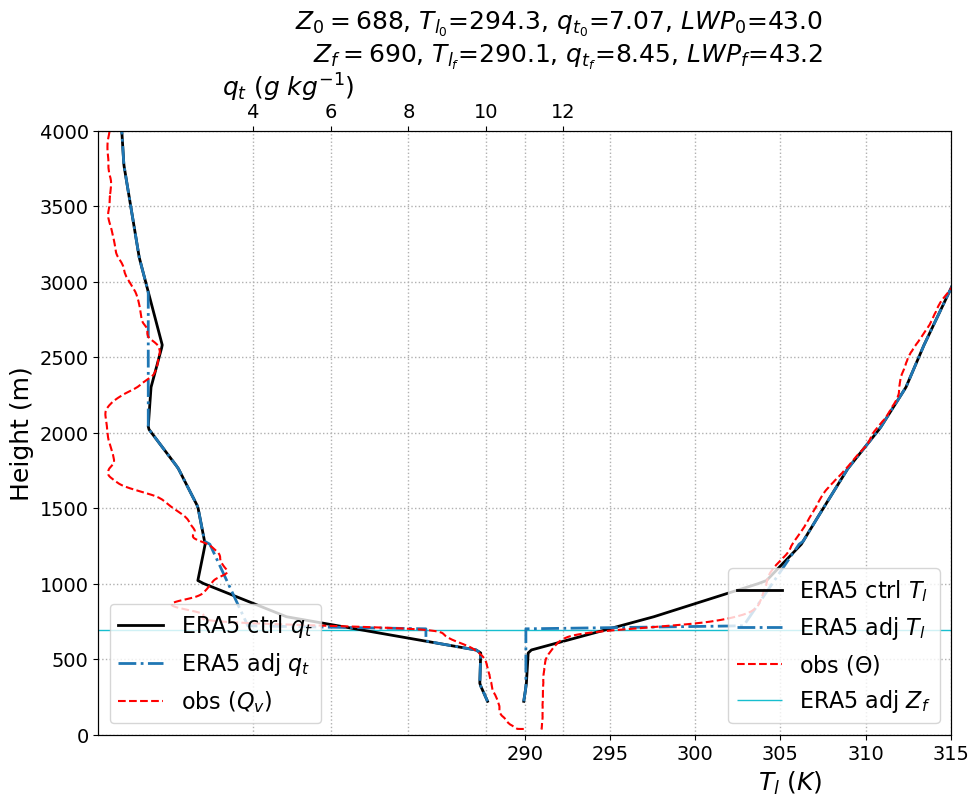

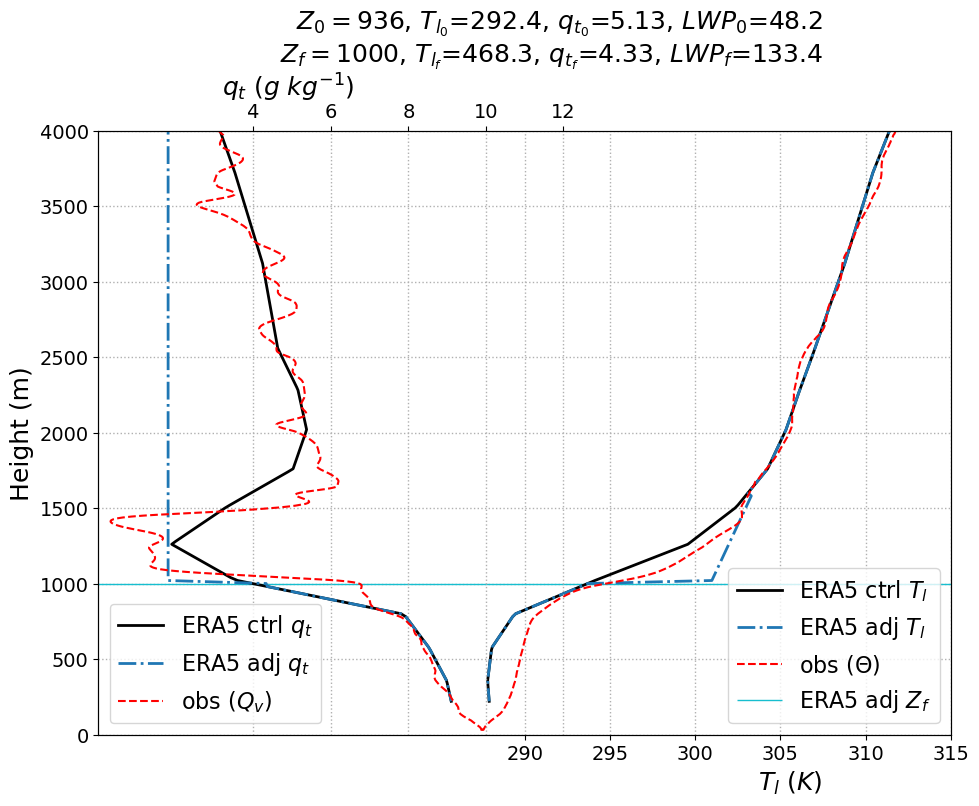

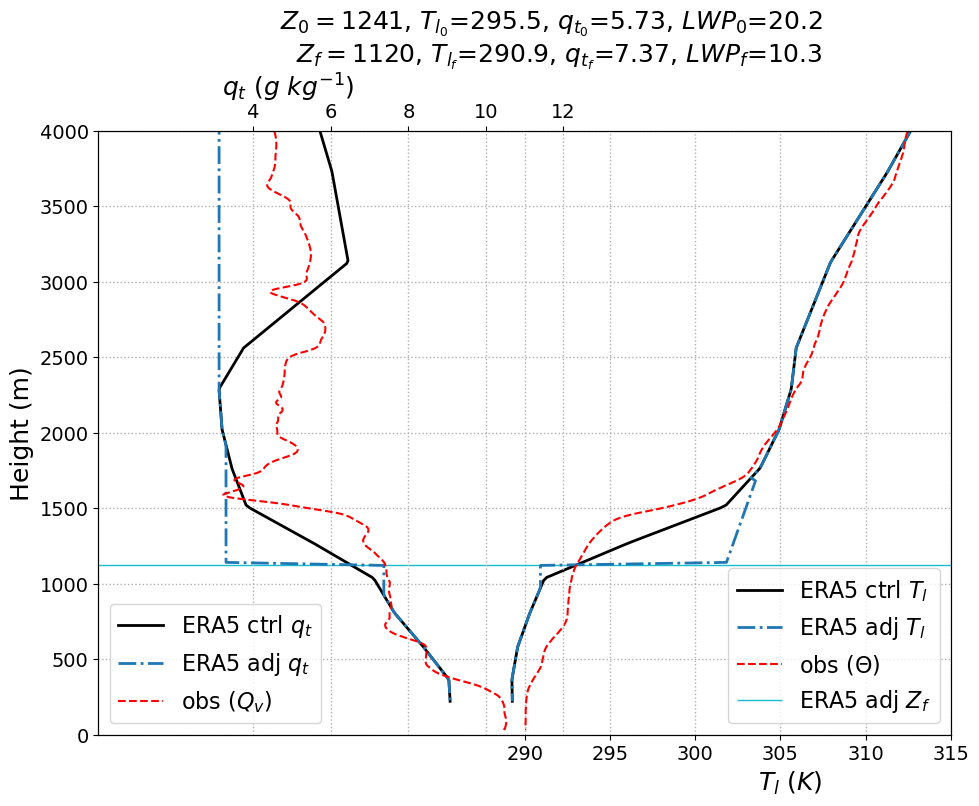

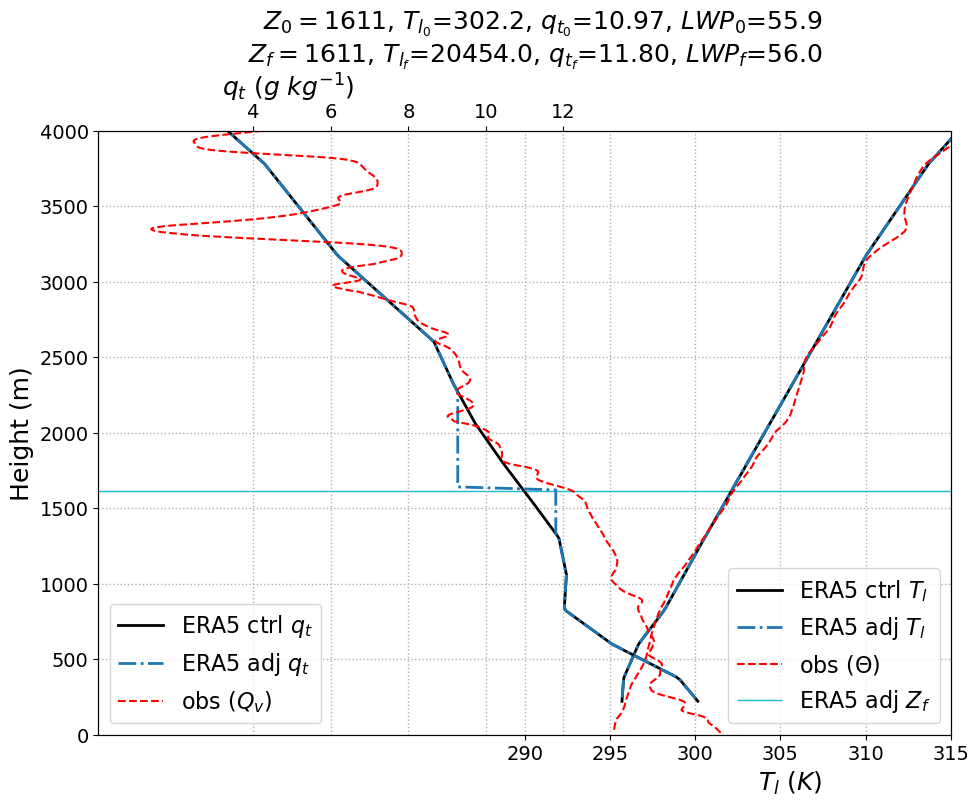

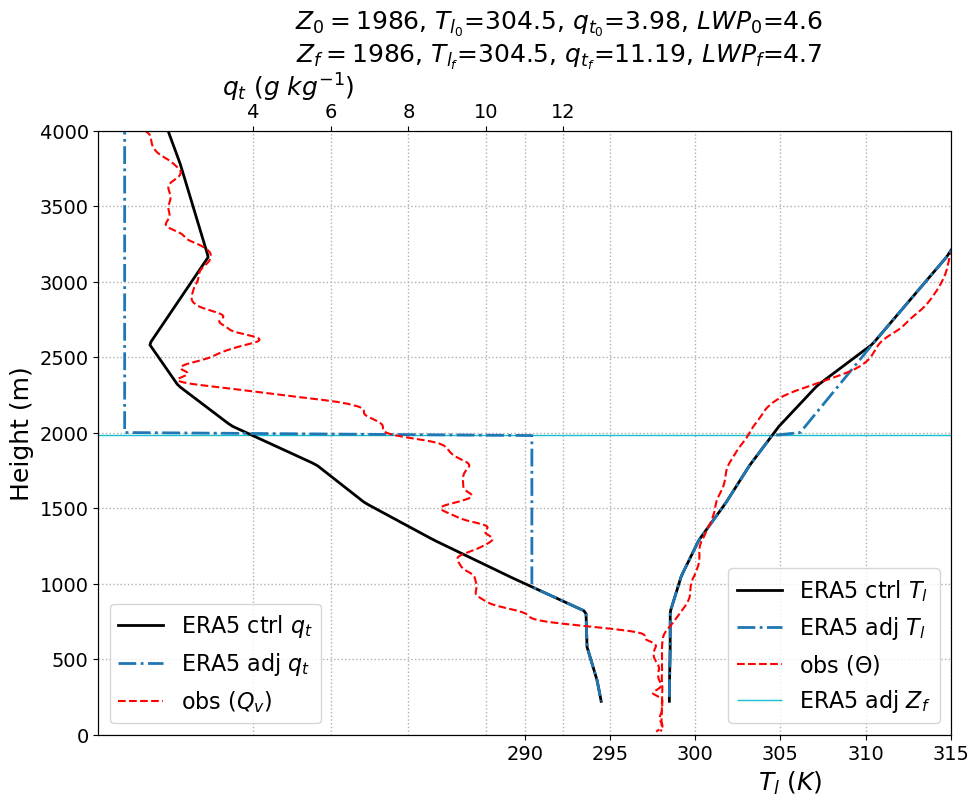

In [9]:
i_list = [2, 15, 31]
sent = [80, 4, 11, 70, 50]
i=80

for i in sent:
    #4 fails, for some reason LWP0 = 0?

    profile_data, ac_data, profile_type, profile_params =  all_profiles[i], all_ac_data[i], profile_types[i], all_profile_params[i]
    vals = extract_from_profile(profile_data, ac_data, profile_type, profile_params, plot_profile=True)
    # fig, ax = plt.subplots()
    # ax.plot(vals['ERA_sharp']['theta_l'], vals['ERA_sharp']['z'])
# ax.plot(vals['ERA_prof']['theta_l'], vals['ERA_prof']['z'])

no ssmi
Target LWP:  1.4921214854801002
Initial values:  493.5681634621121 291.61875520737607 7.289619678661516
Final values:  [ 4.89999994e+02  2.91251211e+02  9.03403710e+00  4.15897070e-01
 -4.57770275e-01] 


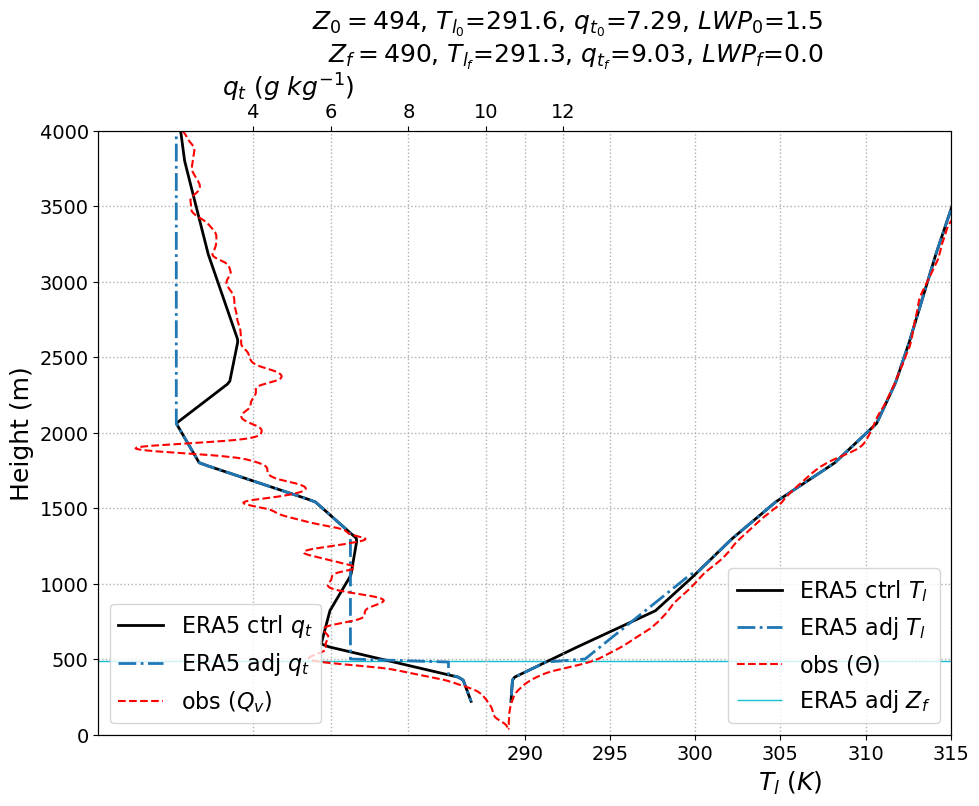

In [8]:
i_list = [2, 15, 31]
sent = [80, 4, 11, 70, 50]
i=80

for i in i_list[0:1]:

    profile_data, ac_data, profile_type, profile_params =  all_profiles[i], all_ac_data[i], profile_types[i], all_profile_params[i]
    vals = extract_from_profile(profile_data, ac_data, profile_type, profile_params, plot_profile=True)

In [59]:
profile_return_data = {i: None for i in range(len(all_profiles))}

In [57]:

profile_return_data = []
# profile_return_data = {i: None for i in len(all_profiles)}

def extract_and_add(d, i, profile_data, ac_data, profile_type, profile_params):
    vals = extract_from_profile(profile_data, ac_data, profile_type, profile_params, sharpen=True)


with mp.Manager() as manager:
        profile_return_data = manager.dict()
        with manager.Pool(10) as pool:
            pool.starmap(extract_from, repeat(d, 10))
        
        
        
timer = lt.LoopTimer(len(all_profiles))
with mp.Pool(processes=10) as pool:
    results = pool.starmap(extract_from_profile, zip(all_profiles, all_ac_data, profile_types, all_profile_params))
    
    for i, (profile_data, ac_data, profile_type, profile_params) in enumerate(zip(all_profiles, all_ac_data, profile_types, all_profile_params)):
    vals = extract_from_profile(profile_data, ac_data, profile_type, profile_params, sharpen=True)
    profile_return_data[i] = (vals)
#     fig, ax = plt.subplots()
#     ax.plot(vals['ERA_sharp']['theta_l'], vals['ERA_sharp']['z'])
#     ax.plot(vals['ERA_prof']['theta_l'], vals['ERA_prof']['z'])
    timer.update(overwrite=True)


no ssmi
Target LWP:  3.7042046144919616
Initial values:  465.94283897892547 294.2632261175221 7.773115294326031
Final values:  [466.04957088 291.27510466  10.2708394    1.72425602  -5.8808667 ] 
0.58%      ETA 13:29:43      time left: 43.4 minutes        no ssmi
Target LWP:  1.006787127093923
Initial values:  470.95404221611534 293.26742380031277 6.694798431743134
Final values:  [4.70954064e+02 2.90603476e+02 8.39274419e+00 3.22413732e-01
 2.10057080e+00] 
1.17%      ETA 13:13:18      time left: 27.0 minutes        no ssmi
Target LWP:  1.4921214854801002
Initial values:  493.5681634621121 291.61875520737607 7.289619678661516
Final values:  [ 4.89999994e+02  2.91251211e+02  9.03403710e+00  4.15897070e-01
 -4.57770275e-01] 
1.75%      ETA 13:13:49      time left: 27.3 minutes        no ssmi
Target LWP:  32.12926873023887
Initial values:  716.4352983236333 293.45923845037703 7.522695065823678
Final values:  [ 6.99993948e+02  2.92901422e+02  9.01286240e+00  5.01942800e-01
 -1.02943654e+00]

KeyboardInterrupt: 

In [23]:


nested = ['profile_inv_hans', 'ERA_inv_hans', 'ERA_inv_hans_regrid', 'ERA_sharp_stats_peter', 'ERA_stats_peter', 'ERA_stats_hans', 'profile_stats_peter', 'profile_stats_hans']
pd_cols = [i for i in profile_return_data[0].keys() if i not in nested]

# ['ERA_inv_peter', 'ERA_lwp_bl', 'ERA_lwp_tot', 
#            'SSMI_lwp', 'AC_lwp', 'profile_inv_peter', 'profile_inv_hans', 'GOES_CTH', 'GOES_CF', 'ERA_prof', 'ERA_sharp', 'SSMI']



for i in nested:
    for k in profile_return_data[0][i].keys():
        pd_cols.append(f'{i}_{k}')
df = pd.DataFrame(columns=pd_cols)
for i, d in enumerate(profile_return_data):
    values_to_add = {}
    
    for k, v in d.items():
        if k in nested:
            for k2, v2 in v.items():
                values_to_add[f'{k}_{k2}'] = v2
        else:
            values_to_add[k] = v
    row_to_add = pd.Series(values_to_add, name=i)
    df = df.append(row_to_add)

In [26]:
df.columns.values

array(['lat', 'lon', 'date', 'ERA_inv_peter', 'ERA_lwp_bl', 'ERA_lwp_tot',
       'SSMI_lwp', 'AC_lwp', 'profile_inv_peter', 'GOES_CTH', 'GOES_CF',
       'ERA_prof', 'ERA_sharp', 'SSMI', 'profile_inv_hans_d_qt',
       'profile_inv_hans_d_theta_e', 'profile_inv_hans_d_theta_l',
       'profile_inv_hans_alpha_thetal', 'profile_inv_hans_alpha_qt',
       'profile_inv_hans_alpha_thetae', 'profile_inv_hans_d_q_inv',
       'profile_inv_hans_d_t_inv', 'profile_inv_hans_t_below_inv',
       'profile_inv_hans_t_above_inv', 'profile_inv_hans_q_below_inv',
       'profile_inv_hans_q_above_inv', 'profile_inv_hans_z_top',
       'profile_inv_hans_z_mid', 'profile_inv_hans_z_bot',
       'profile_inv_hans_i_top', 'profile_inv_hans_i_mid',
       'profile_inv_hans_i_bot', 'profile_inv_hans_d_tl_inv',
       'profile_inv_hans_d_te_inv', 'profile_inv_hans_lat',
       'profile_inv_hans_lon', 'profile_inv_hans_lon_p',
       'profile_inv_hans_time', 'ERA_inv_hans_z_top',
       'ERA_inv_hans_z_mid', 

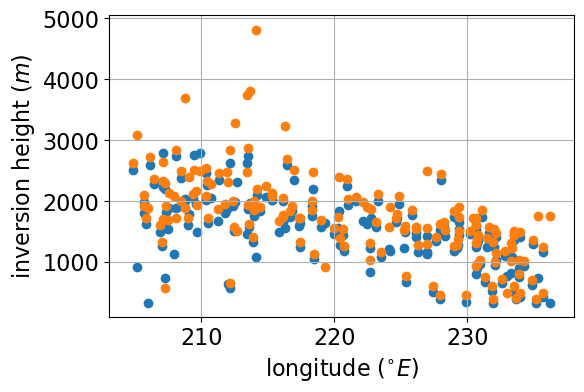

In [29]:
plt.scatter(df.lon, df.profile_inv_hans_z_bot)
plt.scatter(df.lon, df.profile_inv_peter)
plt.xlabel('longitude ($^{\circ}E$)')
plt.ylabel('inversion height ($m$)')
plt.grid(True)

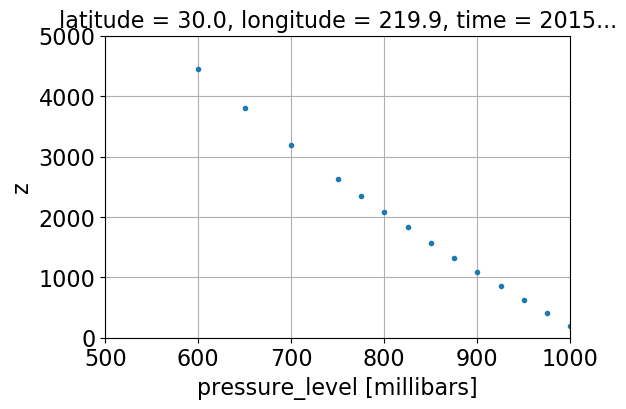

In [54]:
ERA_profile = ERA_data.isel(time=0).sel(latitude=30, longitude=220, method='nearest')
fig, ax = plt.subplots()
(ERA_profile.z/9.81).plot(ax=ax, lw=0, marker='.')
ax.set_ylim(0,5000)
ax.set_xlim(500,1000)
ax.grid(True)

LinregressResult(slope=0.8898164212296541, intercept=0.8554212012462923, rvalue=0.9475036486831143, pvalue=4.157089448425644e-85, stderr=0.023166935207486687)
LinregressResult(slope=0.8563805299390791, intercept=0.3332828606516074, rvalue=0.9127006456120654, pvalue=3.396841278079407e-67, stderr=0.029580996804350345)
LinregressResult(slope=0.7203769028921113, intercept=0.8160747977288487, rvalue=0.8393887939977963, pvalue=3.2364708011526084e-44, stderr=0.0368774863732959)
LinregressResult(slope=0.841280125414414, intercept=0.3884519293229587, rvalue=0.8284107767656715, pvalue=5.437672501360466e-32, stderr=0.051926153935403355)


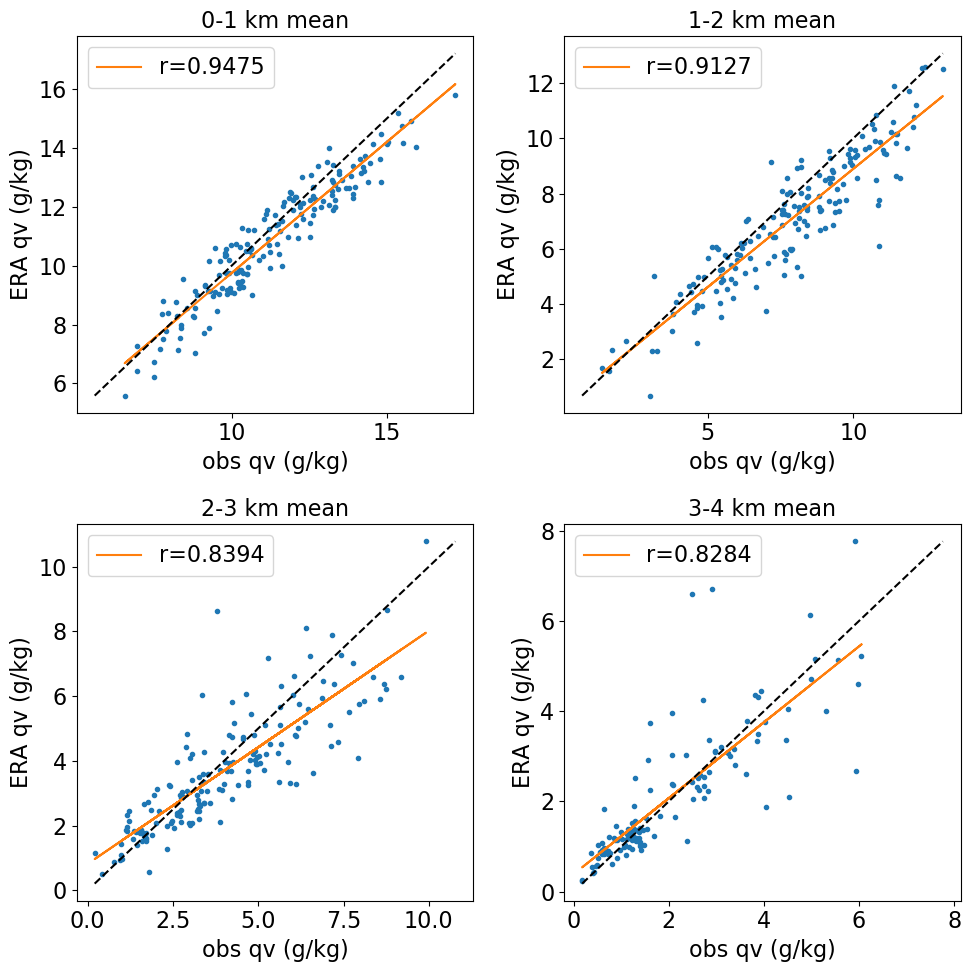

In [38]:

df_plot = df[df['profile_stats_hans_q_1_2_km']*1000 < 40]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axl = ax.flatten()
plot_with_regression(df_plot.profile_stats_hans_q_0_1_km*1000, df_plot.ERA_stats_hans_q_0_1_km*1000, x_label='obs qv (g/kg)', y_label='ERA qv (g/kg)', ax=axl[0])
axl[0].set_title('0-1 km mean')
plot_with_regression(df_plot.profile_stats_hans_q_1_2_km*1000, df_plot.ERA_stats_hans_q_1_2_km*1000, x_label='obs qv (g/kg)', y_label='ERA qv (g/kg)', ax=axl[1])
axl[1].set_title('1-2 km mean')
plot_with_regression(df_plot.profile_stats_hans_q_2_3_km*1000, df_plot.ERA_stats_hans_q_2_3_km*1000, x_label='obs qv (g/kg)', y_label='ERA qv (g/kg)', ax=axl[2])
axl[2].set_title('2-3 km mean')
plot_with_regression(df_plot.profile_stats_hans_q_3_4_km*1000, df_plot.ERA_stats_hans_q_3_4_km*1000, x_label='obs qv (g/kg)', y_label='ERA qv (g/kg)', ax=axl[3])
axl[3].set_title('3-4 km mean')
plt.tight_layout()
---

In [19]:
ERA_inv_hans, ERA_inv_hans_rg, ERA_inv_peter, ERA_lwp_bl, ERA_lwp_tot, SSMI_lwp, MODIS_cth, \
    profile_inv_peter, profile_inv_hans, ERA_qv_above_inv_entraining, ERA_qv_above_inv_radiating, \
    true_qv_above_inv_entraining, true_qv_above_inv_radiating, GOES_cth, GOES_cf = ([], [], [], [], [], 
        [], [], [], [], [], [], [], [] ,[], [])

ERA_inv_peter_old, profile_inv_peter_old = [], []






ERA_delta_theta_inv = []
ERA_delta_q_inv = []
ERA_q_upper_bl = []
ERA_q_lower_ft = []
ERA_alpha_q = []
ERA_alpha_theta = []
                
profile_delta_theta_inv = []
profile_delta_q_inv = []
profile_q_upper_bl = []
profile_q_lower_ft = []
profile_alpha_q = []
profile_alpha_theta = []
profile_q_0_1_km = []
profile_q_0_1_km = []
profile_q_0_1_km = []
profile_q_0_1_km = []

ERA_sharp_delta_theta_inv = []
ERA_sharp_delta_q_inv = []
ERA_sharp_q_upper_bl = []
ERA_sharp_q_lower_ft = []
ERA_sharp_alpha_q = []
ERA_sharp_alpha_theta = []

ERA_profiles = []
for d in profile_return_data:
    ERA_inv_hans.append(d['ERA_inv_hans']['z_mid'])
    ERA_inv_hans_rg.append(d['ERA_inv_hans_regrid']['z_mid'])
    ERA_inv_peter.append(d['ERA_inv_peter'])
    ERA_inv_peter_old.append(d['ERA_inv_peter_old'])
    ERA_lwp_bl.append(d['ERA_lwp_bl'])
    ERA_lwp_tot.append(d['ERA_lwp_tot'])
    SSMI_lwp.append(d['SSMI_lwp'])
#     MODIS_cth.append(d['MODIS_CTH_ryan'])
    profile_inv_peter.append(d['true_inv_peter'])
    profile_inv_peter_old.append(d['true_inv_peter_old'])
    profile_inv_hans.append(d['true_inv_hans']['z_mid'])
    ERA_qv_above_inv_entraining.append(d['ERA_qv_above_inv_entraining'])
    ERA_qv_above_inv_radiating.append(d['ERA_qv_above_inv_radiating'])
    true_qv_above_inv_entraining.append(d['true_qv_above_inv_entraining'])
    true_qv_above_inv_radiating.append(d['true_qv_above_inv_radiating'])
    GOES_cth.append(d['GOES_CTH'])
    GOES_cf.append(d['GOES_CF'])
    ERA_profiles.append(d['ERA_prof'])
                
    stats = d['ERA_stats_hans']
    ERA_delta_theta_inv.append(stats['delta_theta_inv'])
    ERA_delta_q_inv.append(stats['delta_q_inv'])
    ERA_q_upper_bl.append(stats['q_upper_bl'])
    ERA_q_lower_ft.append(stats['q_lower_ft'])
    ERA_alpha_q.append(stats['alpha_q'])
    ERA_alpha_theta.append(stats['alpha_theta'])

    stats = d['profile_stats_hans']
    profile_delta_theta_inv.append(stats['delta_theta_inv'])
    profile_delta_q_inv.append(stats['delta_q_inv'])
    profile_q_upper_bl.append(stats['q_upper_bl'])
    profile_q_lower_ft.append(stats['q_lower_ft'])
    profile_alpha_q.append(stats['alpha_q'])
    profile_alpha_theta.append(stats['alpha_theta'])

    
    stats = d['ERA_sharp_stats_peter']
    ERA_sharp_delta_theta_inv.append(stats['delta_theta_inv'])
    ERA_sharp_delta_q_inv.append(stats['delta_q_inv'])
    ERA_sharp_q_upper_bl.append(stats['q_upper_bl'])
    ERA_sharp_q_lower_ft.append(stats['q_lower_ft'])
    ERA_sharp_alpha_q.append(stats['alpha_q'])
    ERA_sharp_alpha_theta.append(stats['alpha_theta'])


df = pd.DataFrame({'ERA_inv_hans': ERA_inv_hans, 
                   'ERA_inv_hans_rg': ERA_inv_hans_rg, 
                   'ERA_inv_peter': ERA_inv_peter,
                   'ERA_inv_peter_old': ERA_inv_peter_old,
                   'ERA_lwp_bl': ERA_lwp_bl, 
                   'ERA_lwp_tot': ERA_lwp_tot, 
#                    'SSMI_lwp': SSMI_lwp, 
#                    'MODIS_cth': MODIS_cth,
                   'profile_inv_peter': profile_inv_peter,
                   'profile_inv_peter_old': profile_inv_peter_old,
                   'profile_inv_hans': profile_inv_hans, 
                   'ERA_qv_above_inv_entraining': ERA_qv_above_inv_entraining, 
                   'ERA_qv_above_inv_radiating': ERA_qv_above_inv_radiating,
                   'true_qv_above_inv_entraining': true_qv_above_inv_entraining, 
                   'true_qv_above_inv_radiating': true_qv_above_inv_radiating, 
                   'GOES_cth': GOES_cth, 
                   'GOES_cf': GOES_cf,
                   
                   
                   'ERA_delta_theta_inv': ERA_delta_theta_inv,
                    'ERA_delta_q_inv': ERA_delta_q_inv,
                    'ERA_q_upper_bl': ERA_q_upper_bl,
                    'ERA_q_lower_ft': ERA_q_lower_ft,
                    'ERA_alpha_q': ERA_alpha_q,
                    'ERA_alpha_theta': ERA_alpha_theta,
                   
                   
                   'ERA_sharp_delta_theta_inv': ERA_sharp_delta_theta_inv,
                    'ERA_sharp_delta_q_inv': ERA_sharp_delta_q_inv,
                    'ERA_sharp_q_upper_bl': ERA_sharp_q_upper_bl,
                    'ERA_sharp_q_lower_ft': ERA_sharp_q_lower_ft,
                    'ERA_sharp_alpha_q': ERA_sharp_alpha_q,
                    'ERA_sharp_alpha_theta': ERA_sharp_alpha_theta,

                    'profile_delta_theta_inv': profile_delta_theta_inv,
                    'profile_delta_q_inv': profile_delta_q_inv,
                    'profile_q_upper_bl': profile_q_upper_bl,
                    'profile_q_lower_ft': profile_q_lower_ft,
                    'profile_alpha_q': profile_alpha_q,
                    'profile_alpha_theta': profile_alpha_theta,                  
                  })

df.true_inv = df.profile_inv_peter

df_low = df[df.true_inv<2000]

LinregressResult(slope=1.0031381778511899, intercept=20.139608709394572, rvalue=0.7922153176452699, pvalue=5.439327442056733e-11, stderr=0.11649117946480927)


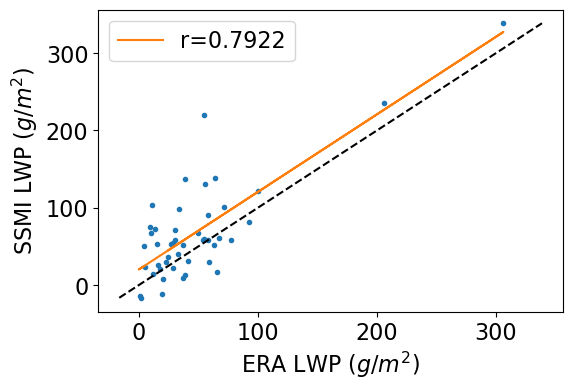

In [37]:
plot_with_regression(np.array(ERA_lwp_tot)*1000,np.array(SSMI_lwp)*1000, x_label='ERA LWP $(g/m^2)$', y_label='SSMI LWP $(g/m^2)$')

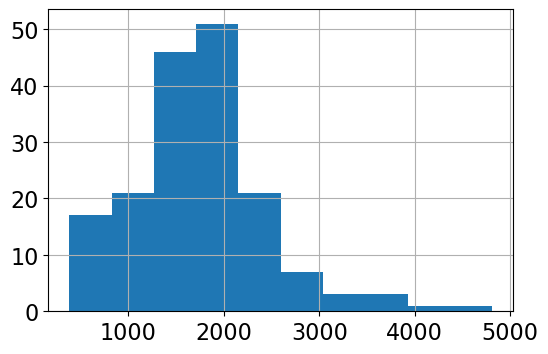

In [118]:
df.profile_inv_peter.hist()

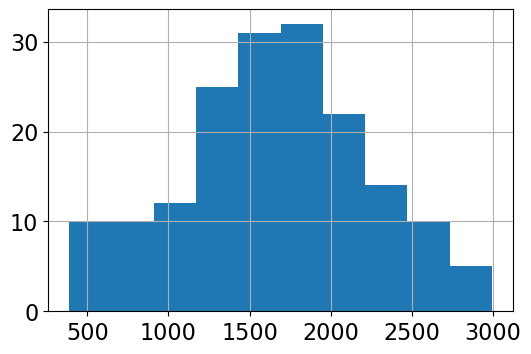

In [119]:
df.profile_inv_hans.hist()

(array([0.00000000e+00, 0.00000000e+00, 1.26984127e-04, 3.17460317e-05,
        2.85714286e-04, 3.17460317e-04, 5.71428571e-04, 1.90476190e-04,
        5.71428571e-04, 9.20634921e-04, 4.44444444e-04, 2.53968254e-04,
        4.12698413e-04, 5.07936508e-04, 1.90476190e-04, 0.00000000e+00,
        6.03174603e-04, 0.00000000e+00, 0.00000000e+00]),
 array([   0.        ,  184.21052632,  368.42105263,  552.63157895,
         736.84210526,  921.05263158, 1105.26315789, 1289.47368421,
        1473.68421053, 1657.89473684, 1842.10526316, 2026.31578947,
        2210.52631579, 2394.73684211, 2578.94736842, 2763.15789474,
        2947.36842105, 3131.57894737, 3315.78947368, 3500.        ]),
 <a list of 19 Patch objects>)

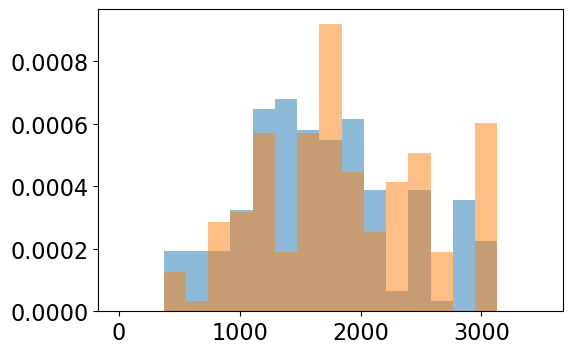

In [120]:
fig, ax = plt.subplots()
ax.hist(df.ERA_inv_peter, bins=np.linspace(0,3500,20), density=True, histtype='bar', alpha=0.5, label='Peter')
ax.hist(df.ERA_inv_hans, bins=np.linspace(0,3500,20), density=True, histtype='bar', alpha=0.5, label='Hans')

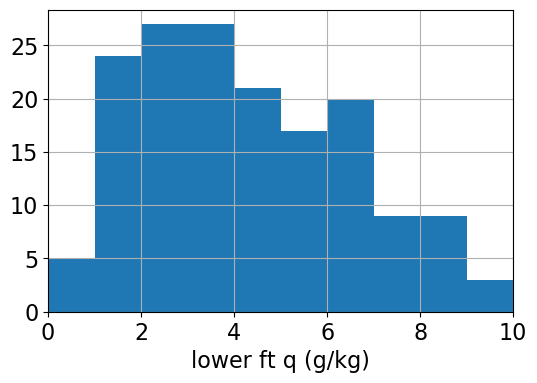

In [121]:
df_plot = df
(df_plot.profile_q_lower_ft*1000).hist(bins=np.linspace(0,10,11))
plt.xlim(0,10)
plt.xlabel('lower ft q (g/kg)');

LinregressResult(slope=0.18407061630033952, intercept=-0.0018392734631574072, rvalue=0.38611212658987243, pvalue=1.9903738935790834e-07, stderr=0.03392814321234268)
LinregressResult(slope=0.39681620703773574, intercept=3.145090966003462, rvalue=0.5953551429235988, pvalue=1.1055158220852619e-17, stderr=0.04131657872427055)
LinregressResult(slope=0.31778855926884547, intercept=0.0036280823840132643, rvalue=0.4172517584570885, pvalue=1.5094237711436736e-08, stderr=0.05340100490399415)
LinregressResult(slope=0.2857443887366483, intercept=0.0024808322507922304, rvalue=0.5386609078024451, pvalue=3.539879164458656e-14, stderr=0.03448174212040276)
LinregressResult(slope=0.1075571129031899, intercept=0.6173929140404781, rvalue=0.1928020064029234, pvalue=0.016237574110194337, stderr=0.04425436250634024)
LinregressResult(slope=0.2626534255348623, intercept=0.42819693424828403, rvalue=0.4268474780430657, pvalue=3.050571453584788e-08, stderr=0.04498715341981142)
LinregressResult(slope=0.82886862118

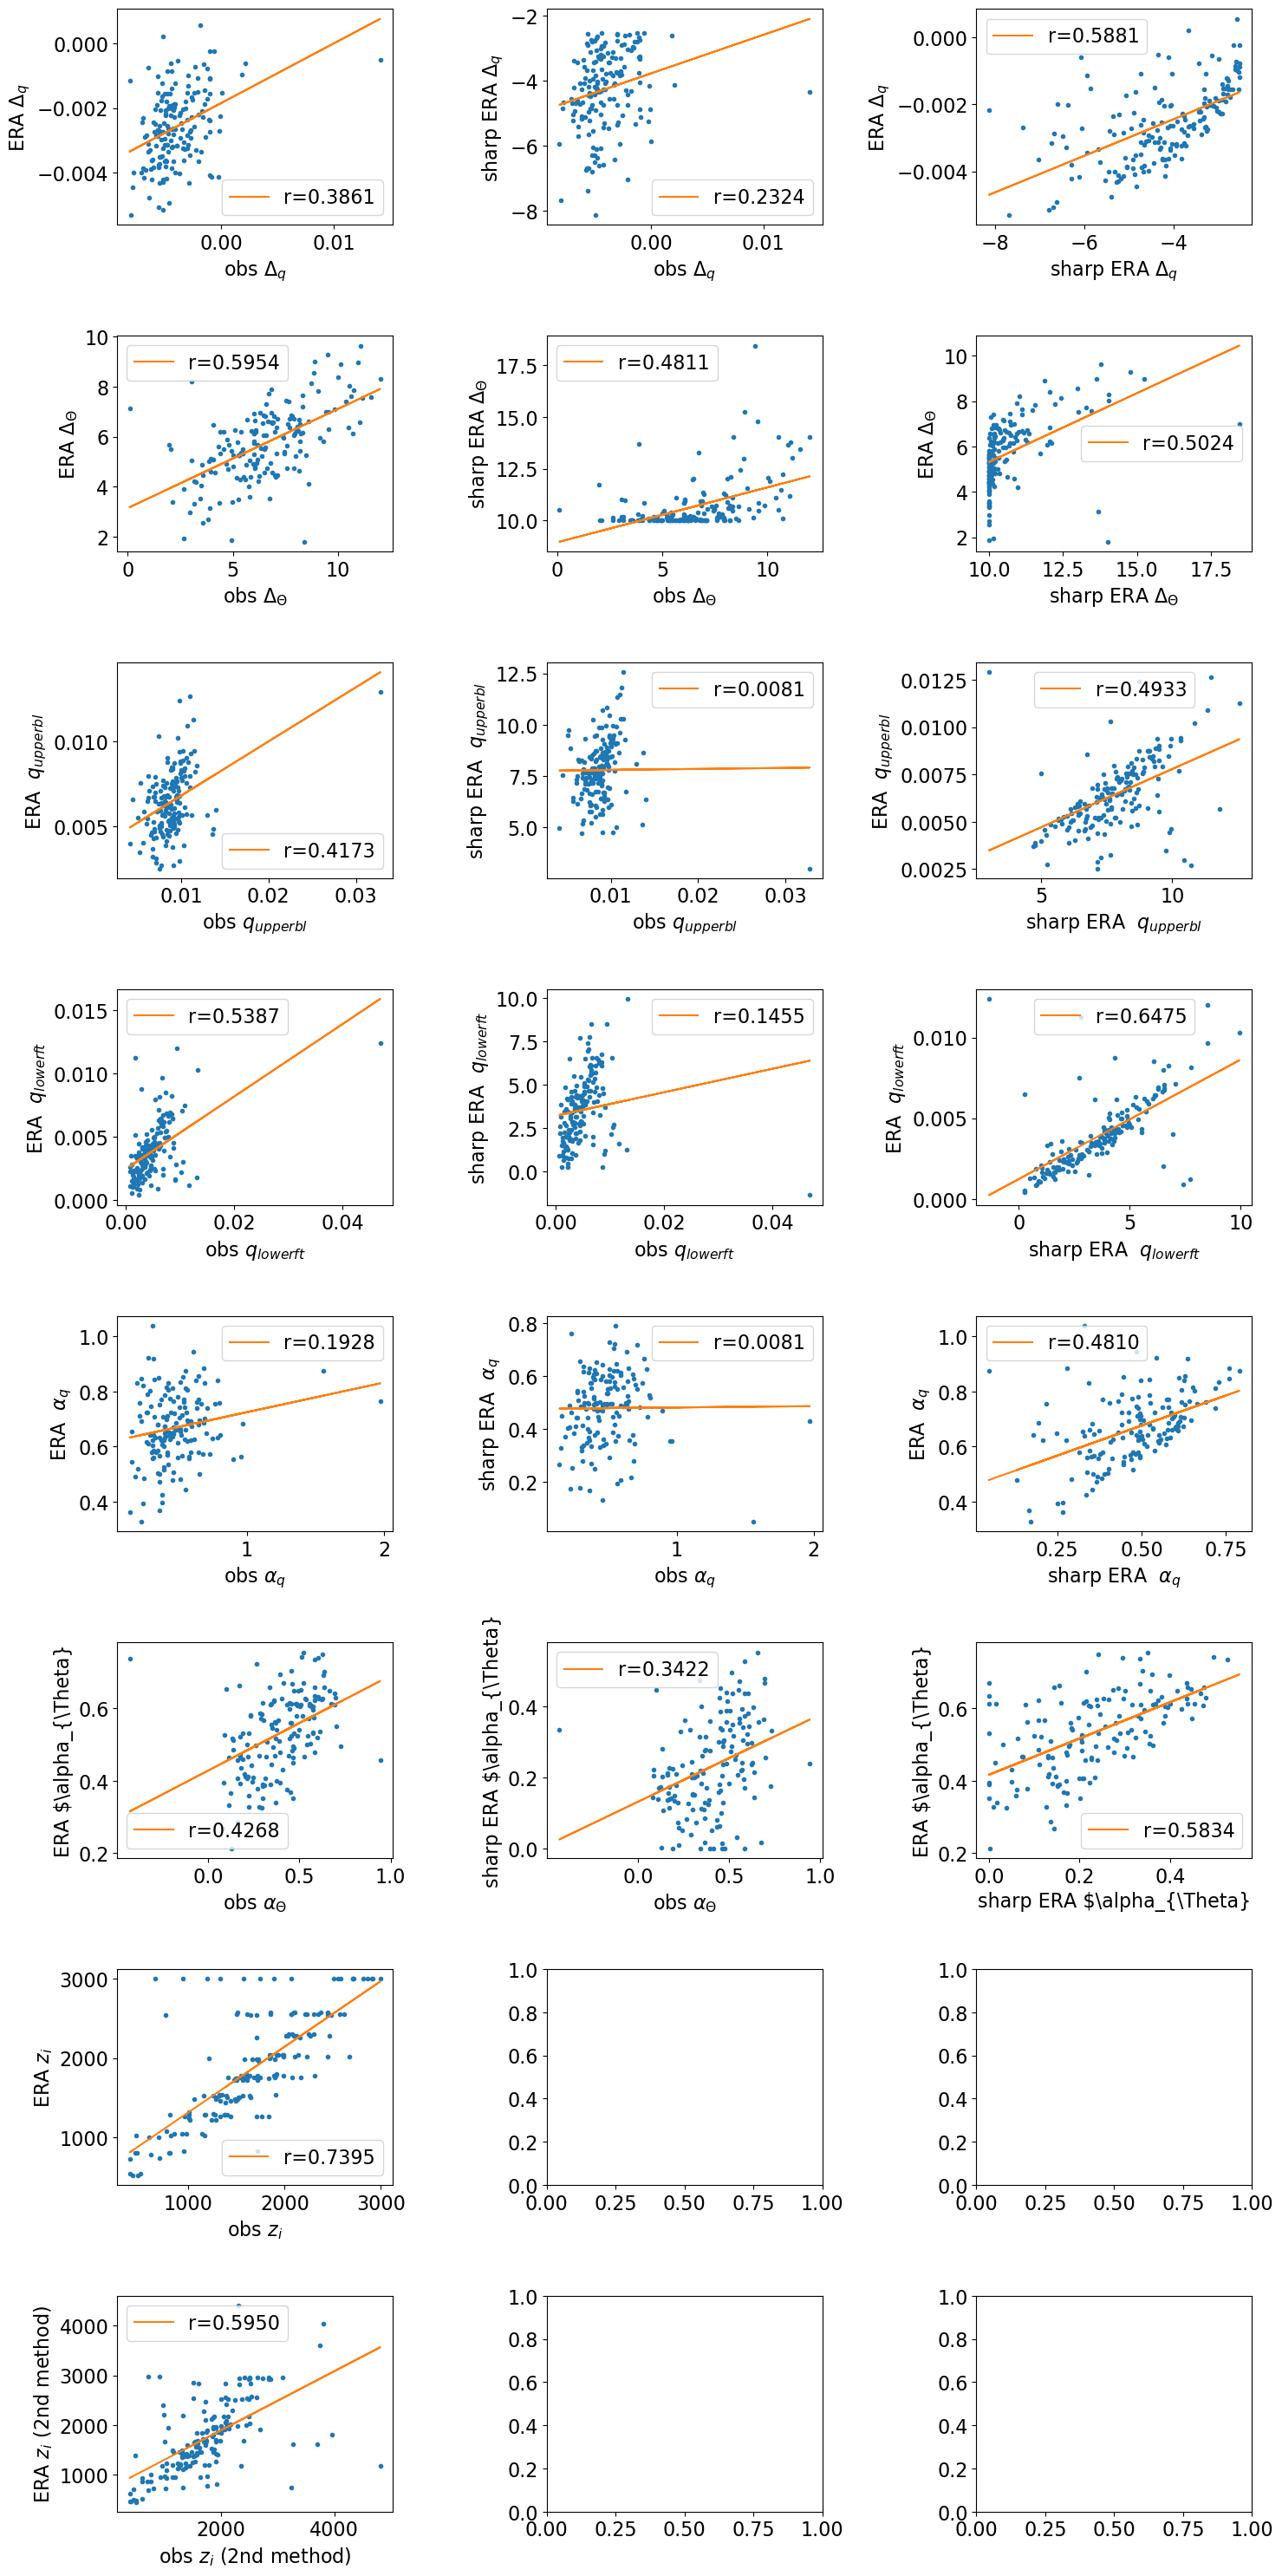

In [124]:


#     stats = d['profile_stats_hans']
#     profile_delta_theta_inv.append(stats['delta_theta_inv'])
#     profile_delta_q_inv.append(stats['delta_q_inv'])
#     profile_q_upper_bl.append(stats['q_upper_bl'])
#     profile_q_lower_ft.append(stats['q_lower_ft'])
#     profile_alpha_q.append(stats['alpha_q'])
#     profile_alpha_theta.append(stats['alpha_theta'])
df_good = df
# df_good = df_good[df_good.profile_delta_q_inv < 0.01]
# df_good = df_good[df_good.ERA_sharp_q_upper_bl < 0.04]
# df_good = df_good[df_good.ERA_sharp_delta_theta_inv < 20]
# df_good = df_good[df_good.profile_alpha_q < 1]
df_plot = df_good
    

    
fig, ax = plt.subplots(ncols=3, nrows=8, figsize=(15,30))

axi = ax[0,0]
plot_with_regression(df_plot.profile_delta_q_inv, df_plot.ERA_delta_q_inv, ax=axi, x_label='obs $\Delta_q$', y_label='ERA $\Delta_q$')
axi = ax[1,0]
plot_with_regression(df_plot.profile_delta_theta_inv, df_plot.ERA_delta_theta_inv, ax=axi, x_label='obs $\Delta_\Theta$', y_label='ERA $\Delta_\Theta$')
axi = ax[2,0]
plot_with_regression(df_plot.profile_q_upper_bl, df_plot.ERA_q_upper_bl, ax=axi, x_label='obs $q_{upperbl}$', y_label='ERA  $q_{upperbl}$')
axi = ax[3,0]
plot_with_regression(df_plot.profile_q_lower_ft, df_plot.ERA_q_lower_ft, ax=axi, x_label='obs $q_{lowerft}$', y_label='ERA  $q_{lowerft}$')
axi = ax[4,0]
plot_with_regression(df_plot.profile_alpha_q, df_plot.ERA_alpha_q, ax=axi, x_label=r'obs $\alpha_q$', y_label=r'ERA  $\alpha_q$')
axi = ax[5,0]
plot_with_regression(df_plot.profile_alpha_theta, df_plot.ERA_alpha_theta, ax=axi, x_label=r'obs $\alpha_{\Theta}$', y_label=r'ERA $\alpha_{\Theta}')
axi = ax[6,0]
plot_with_regression(df_plot.profile_inv_hans, df_plot.ERA_inv_hans, ax=axi, x_label=r'obs $z_i$', y_label=r'ERA $z_i$')
axi = ax[7,0]
plot_with_regression(df_plot.profile_inv_peter, df_plot.ERA_inv_peter, ax=axi, x_label=r'obs $z_i$ (2nd method)', y_label=r'ERA $z_i$ (2nd method)')


axi = ax[0,1]
plot_with_regression(df_plot.profile_delta_q_inv, df_plot.ERA_sharp_delta_q_inv, ax=axi, x_label='obs $\Delta_q$', y_label='sharp ERA $\Delta_q$')
axi = ax[1,1]
plot_with_regression(df_plot.profile_delta_theta_inv, df_plot.ERA_sharp_delta_theta_inv, ax=axi, x_label='obs $\Delta_\Theta$', y_label='sharp ERA $\Delta_\Theta$')
axi = ax[2,1]
plot_with_regression(df_plot.profile_q_upper_bl, df_plot.ERA_sharp_q_upper_bl, ax=axi, x_label='obs $q_{upperbl}$', y_label='sharp ERA  $q_{upperbl}$')
axi = ax[3,1]
plot_with_regression(df_plot.profile_q_lower_ft, df_plot.ERA_sharp_q_lower_ft, ax=axi, x_label='obs $q_{lowerft}$', y_label='sharp ERA  $q_{lowerft}$')
axi = ax[4,1]
plot_with_regression(df_plot.profile_alpha_q, df_plot.ERA_sharp_alpha_q, ax=axi, x_label=r'obs $\alpha_q$', y_label=r'sharp ERA  $\alpha_q$')
axi = ax[5,1]
plot_with_regression(df_plot.profile_alpha_theta, df_plot.ERA_sharp_alpha_theta, ax=axi, x_label=r'obs $\alpha_{\Theta}$', y_label=r'sharp ERA $\alpha_{\Theta}')
axi = ax[6,1]
# plot_with_regression(df_plot.profile_inv_hans, df_plot.ERA_sharp_inv_hans, ax=axi, x_label=r'obs $z_i$', y_label=r'sharp ERA $z_i$')
# axi = ax[7,1]
# plot_with_regression(df_plot.profile_inv_peter, df_plot.ERA_sharp_inv_peter, ax=axi, x_label=r'obs $z_i$ (2nd method)', y_label=r'sharp ERA $z_i$ (2nd method)')


axi = ax[0,2]
plot_with_regression(df_plot.ERA_sharp_delta_q_inv, df_plot.ERA_delta_q_inv, ax=axi, x_label='sharp ERA $\Delta_q$', y_label='ERA $\Delta_q$')
axi = ax[1,2]
plot_with_regression(df_plot.ERA_sharp_delta_theta_inv, df_plot.ERA_delta_theta_inv, ax=axi, x_label='sharp ERA $\Delta_\Theta$', y_label='ERA $\Delta_\Theta$')
axi = ax[2,2]
plot_with_regression(df_plot.ERA_sharp_q_upper_bl, df_plot.ERA_q_upper_bl, ax=axi, x_label='sharp ERA  $q_{upperbl}$', y_label='ERA  $q_{upperbl}$')
axi = ax[3,2]
plot_with_regression(df_plot.ERA_sharp_q_lower_ft, df_plot.ERA_q_lower_ft, ax=axi, x_label='sharp ERA  $q_{lowerft}$', y_label='ERA  $q_{lowerft}$')
axi = ax[4,2]
plot_with_regression(df_plot.ERA_sharp_alpha_q, df_plot.ERA_alpha_q, ax=axi, x_label=r'sharp ERA  $\alpha_q$', y_label=r'ERA  $\alpha_q$')
axi = ax[5,2]
plot_with_regression(df_plot.ERA_sharp_alpha_theta, df_plot.ERA_alpha_theta, ax=axi, x_label=r'sharp ERA $\alpha_{\Theta}', y_label=r'ERA $\alpha_{\Theta}')
# axi = ax[6,2]
# plot_with_regression(df_plot.ERA_sharp_inv_hans, df_plot.ERA_inv_hans, ax=axi, x_label=r'sharp ERA $z_i$', y_label=r'ERA $z_i$')
# axi = ax[7,2]
# plot_with_regression(df_plot.ERA_sharp_inv_peter, df_plot.ERA_inv_peter, ax=axi, x_label=r'sharp ERA $z_i$ (2nd method)', y_label=r'ERA $z_i$ (2nd method)')




plt.tight_layout()

In [142]:
ERA_profile = ERA_profiles[18]
z, t, p, r = ERA_profile.z.values.copy()/9.81, ERA_profile.t.values.copy(), ERA_profile.level.values.copy(), ERA_profile.r.values.copy()
ql = ERA_profile.clwc.values.copy()
theta = met_utils.theta_from_p_T(p, t)
theta_l = met_utils.get_liquid_water_theta(t, theta, ql)
ERA_inv_peter = met_utils.Peter_inv(z, r, theta_l)
print(ERA_inv_peter)

2824.4348240614945


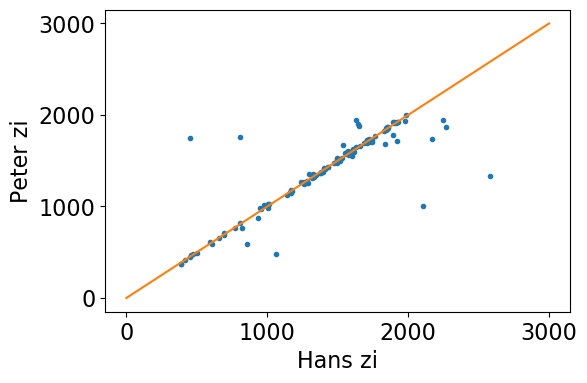

In [143]:
plt.plot(df_low.profile_inv_hans, df_low.profile_inv_peter, '.')
plt.xlabel('Hans zi')
plt.ylabel('Peter zi')
plt.plot([0, 3000], [0, 3000])
# plt.xlim(0, 5000)

LinregressResult(slope=0.6435399459804229, intercept=618.3323971103248, rvalue=0.6825930911951034, pvalue=8.55353586042201e-25, stderr=0.052999040549737184)
LinregressResult(slope=0.7311752967336078, intercept=385.6818399310748, rvalue=0.7359419161934826, pvalue=1.9620740405963802e-30, stderr=0.05174304075611072)


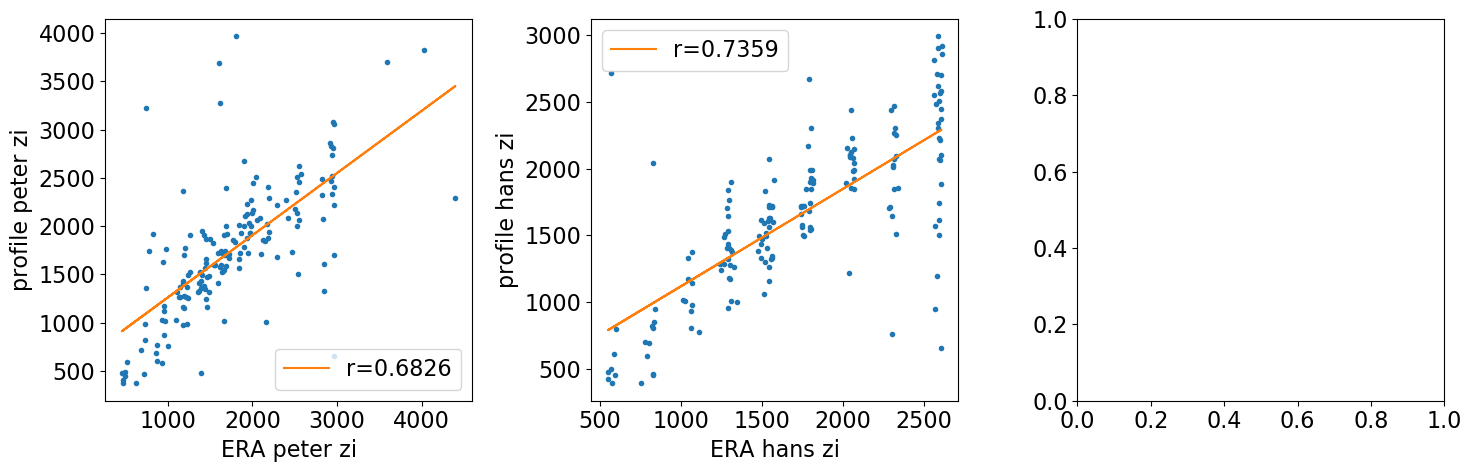

In [145]:
df_plot = df 
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(15,5))
plot_with_regression(df_plot.ERA_inv_peter, df_plot.profile_inv_peter, ax=ax1, x_label='ERA peter zi', y_label='profile peter zi')
plot_with_regression(df_plot.ERA_inv_hans, df_plot.profile_inv_hans, ax=ax2, x_label='ERA hans zi', y_label='profile hans zi')
# plot_with_regression(df.ERA_inv_peter_old, df.profile_inv_peter_old, ax=ax3, x_label='ERA peter_old zi', y_label='profile peter_old zi')
plt.tight_layout()

In [374]:
data_arr = np.vstack((ERA_inv_hans, ERA_inv_peter, ERA_lwp_bl, SSMI_lwp, MODIS_cth, ERA_qv_above_inv_entraining,
                      ERA_qv_above_inv_radiating, GOES_cth, GOES_cf)).T
data_arr = np.vstack((ERA_inv_hans,
                      GOES_cth, MODIS_cth)).T
pred_arr = np.array(profile_inv_peter)

In [375]:
#filter for only shallow ones

In [382]:

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

X = data_arr
y = pred_arr

imp.fit(X)
X = imp.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

from sklearn.preprocessing import StandardScaler
x_test_old = X_test.copy()

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('Hans dummy Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, x_test_old[:,1])))

Mean Absolute Error: 398.01281777875835
Mean Squared Error: 342001.0799540778
Root Mean Squared Error: 584.8085840290631
Hans dummy Root Mean Squared Error: 1782.348990675897


LinregressResult(slope=0.2630111954967933, intercept=1275.8246594168995, rvalue=0.6018195327879514, pvalue=0.0001311144157748019, stderr=0.06075720049890912)
LinregressResult(slope=0.6491013622703857, intercept=630.2591113805727, rvalue=0.8112929212498396, pvalue=3.398605727430777e-09, stderr=0.08142660069549269)


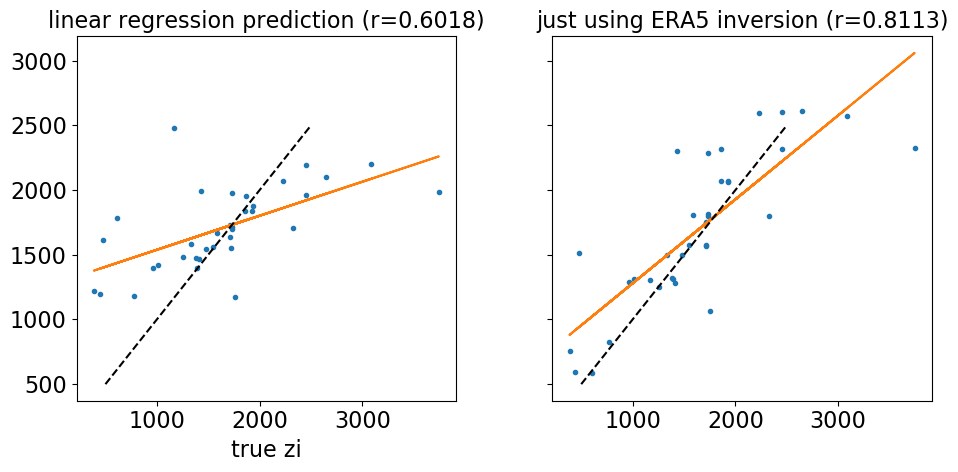

In [386]:
fig, [ax,ax2] = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
ax.plot(y_test, y_pred, '.')
ax.set_xlabel('true zi')
# ax.set_
ax2.plot(y_test, x_test_old[:,0], '.')
lr = linregress(y_test, y_pred)
print(lr)
ax.plot(y_test, lr.intercept+lr.slope*np.array(y_test))#, label=f' sharpened fit (r={lr.rvalue:0.4f})')

lr2 = linregress(y_test, x_test_old[:,0])
ax2.plot(y_test, lr2.intercept+lr2.slope*np.array(y_test))#, label=f' sharpened fit (r={lr.rvalue:0.4f})')

print(lr2)
for axi in [ax, ax2]:
    axi.plot([500,2500],[500,2500], 'k--')
ax.set_title(f'linear regression prediction (r={lr.rvalue:0.4f})')

ax2.set_title(f'just using ERA5 inversion (r={lr2.rvalue:0.4f})')
plt.tight_layout()

TypeError: only integer scalar arrays can be converted to a scalar index

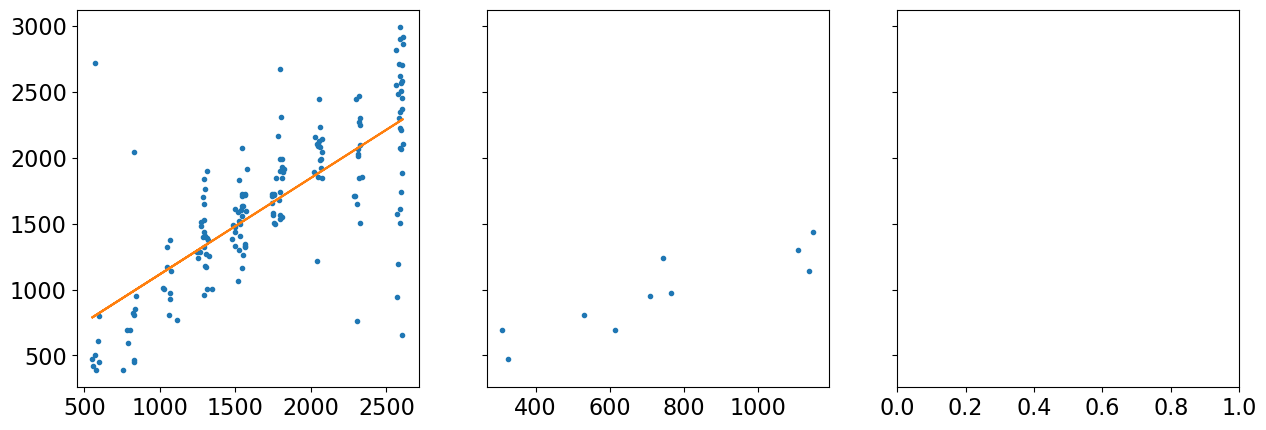

In [256]:
fig, [ax, ax2, ax3] = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
ax.plot(ERA_inv_hans, profile_inv_hans, '.')

lr2 = linregress(ERA_inv_hans, profile_inv_hans)
ax.plot(ERA_inv_hans, lr2.intercept+lr2.slope*np.array(ERA_inv_hans))#, label=f' sharpened fit (r={lr.rvalue:0.4f})')

ax2.plot(np.array(MODIS_cth)*1000, profile_inv_hans, '.')

lr2 = linregress(np.array(MODIS_cth)*1000, profile_inv_hans)
good = ~np.isnan(MODIS_cth)

ax2.plot((np.array(MODIS_cth)*1000)[good], lr2.intercept+lr2.slope*np.array(np.array(MODIS_cth)*1000))#, label=f' sharpened fit (r={lr.rvalue:0.4f})')

ax3.plot(np.array(GOES_cth)*1000, profile_inv_hans, '.')
good = ~np.isnan(GOES_cth)
lr2 = linregress(np.array(GOES_cth[good])*1000, profile_inv_hans[good])
ax3.plot(np.array(GOES_cth[good])*1000, lr2.intercept+lr2.slope*np.array(np.array(GOES_cth[good])*1000))#, label=f' sharpened fit (r={lr.rvalue:0.4f})')

for axi in [ax, ax2, ax3]:
    axi.set_xlim(0, 2500)
    axi.set_ylim(0, 2500)
ax.set_ylabel('"true" $z_i$')
ax.set_xlabel('ERA zi')
ax2.set_xlabel('MODIS CTH')
ax3.set_xlabel('GOES CTH')

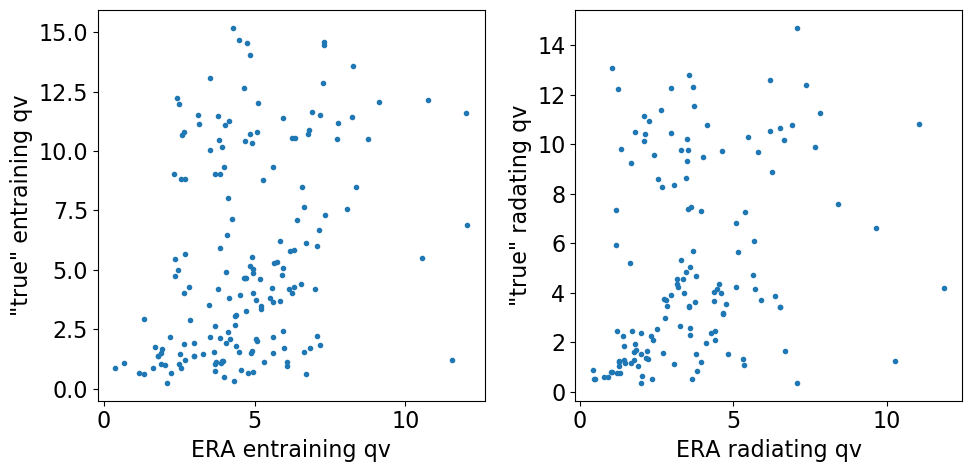

In [246]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(10,5))
ax.plot(np.array(ERA_qv_above_inv_entraining)*1000, np.array(true_qv_above_inv_entraining)*1000, '.')
ax.set_ylabel('"true" entraining qv')
ax.set_xlabel('ERA entraining qv')
ax2.plot(np.array(ERA_qv_above_inv_radiating)*1000, np.array(true_qv_above_inv_radiating)*1000, '.')
ax2.set_ylabel('"true" radating qv')
ax2.set_xlabel('ERA radiating qv')
plt.tight_layout()

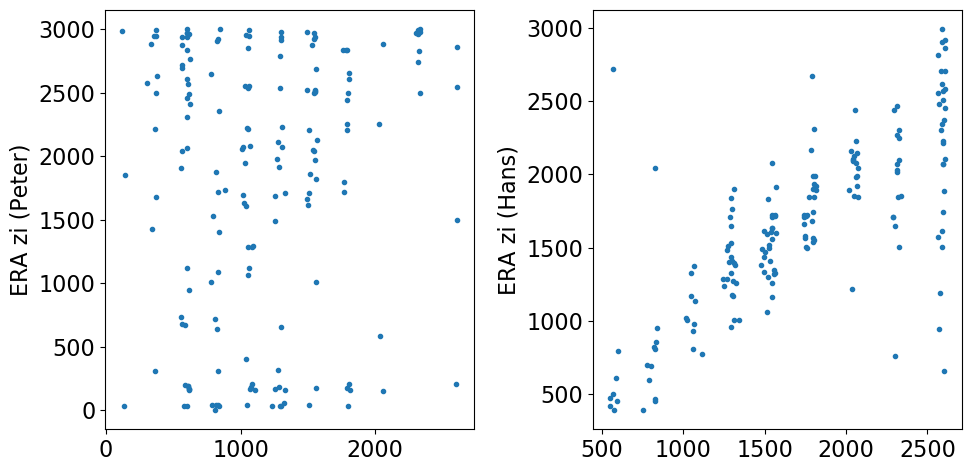

In [253]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(10,5))
ax.plot(ERA_inv_peter, profile_inv_peter, '.')
ax.set_ylabel('"true" zi (Peter)')
ax.set_ylabel('ERA zi (Peter)')
ax2.plot(ERA_inv_hans, profile_inv_hans, '.')
ax2.set_ylabel('"true" zi (Hans)')
ax2.set_ylabel('ERA zi (Hans)')
plt.tight_layout()

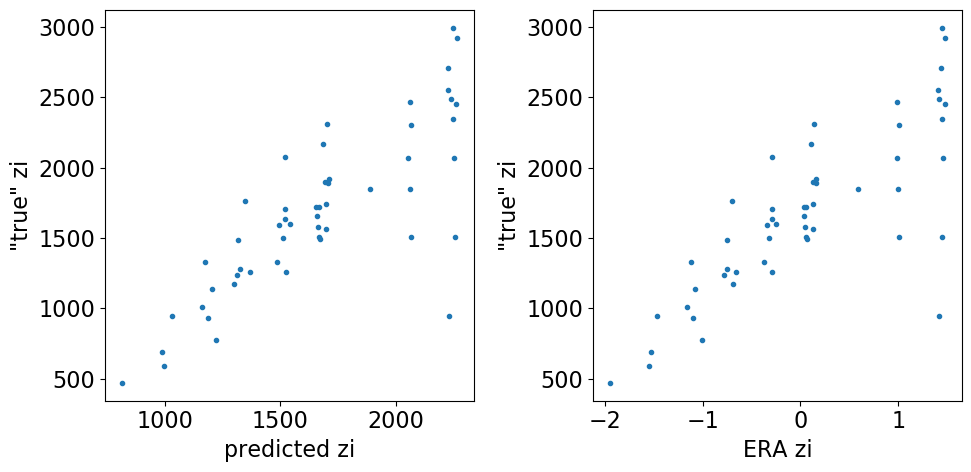

In [247]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(10,5))
ax.plot(y_pred, y_test, '.')
ax.set_xlabel('predicted zi')
ax.set_ylabel('"true" zi')
ax2.plot(X_test[:,0], y_test, '.')
ax2.set_ylabel('"true" zi')
ax2.set_xlabel('ERA zi')
plt.tight_layout()

In [ ]:
#plot of ERA qv vs profile qv (entraining)
#plot of ERA qv vs profile qv (radiating)
#plot of ERA zi peter vs profile zi peter
#plot of ERA zi hans vs profile zi hans


In [ ]:
old_ERA_invs = []
new_ERA_invs = []
prof_invs = []
ERA_lwps = []
SSMI_lwps = []
SSMI_samples = []
SSMI_tot_samples = []

In [ ]:
all_profiles = []
profile_types = []
all_profile_params = []
ac_data = []

In [10]:


    lwp_bl = -np.trapz((ql*rho)[z<ERA_inv['z_top']], z[z<ERA_inv['z_top']]) # should be in kg/m3
    lwp_tot = -np.trapz((ql*rho), z) # should be in kg/m3

    inv = ERA_inv

    assert(np.all(np.diff(z)<0)) # gotta have a descending profile. When this breaks, flip it
    #~moist lapse rate from inv top to surface
    #ft_lapse_rate = 9.8
    ft_lapse_rate = 6.5
    t_ft_dry = t[inv['i_top']] - ft_lapse_rate*(z - z[inv['i_top']])/1000


    #surface LCL
    t_dew = t-(100-r)/5.0
    lcl = met_utils.calculate_LCL(t, t_dew, z)
    lower_bl_lcl = np.nanmax([np.nanmean(lcl[z<inv['z_bot']/2]), np.nanmin(z)])
    i_lcl = np.nanargmin(np.abs(z-lower_bl_lcl))
    lower_bl_lcl = z[i_lcl] # just fixing it to a pressure level
    lower_bl_lcl = inv['z_bot']
    i_lcl = inv['i_bot']
    #actual moist adiabatic lapse rate from sfc lcl
    gamma_m = met_utils.get_moist_adiabatic_lapse_rate(t, p)
    base_of_moist_adiabat = lower_bl_lcl
    cumsums = np.insert(np.cumsum(np.diff(z)*(gamma_m[1:] + gamma_m[:-1])/2), 0, 0)

    t_bl_moist = t[i_lcl] + cumsums[i_lcl] - cumsums

    middle_t = (t_ft_dry[inv['i_mid']]+t_bl_moist[inv['i_mid']])/2
    t_sharpest_inv = np.concatenate((
        t[0:inv['i_top']],
        t_ft_dry[inv['i_top']:inv['i_mid']], 
        [middle_t], 
        t_bl_moist[inv['i_mid']+1:i_lcl],
        t[i_lcl:]))


    ERA_inv_new = met_utils.quick_inversion(z, t_sharpest_inv, p)

In [11]:
for prof in profile_data.values():
    data = prof['sounding']
    lat, lon, date = data['GGLAT'][0], data['GGLON'][0]%360, data['TIME'][0]
    ERA_profile = ERA_data.sel(time=date, method='nearest', tolerance=np.timedelta64(1, 'h'))
    ERA_profile = ERA_profile.sel(latitude=lat, longitude=lon, method='nearest', tolerance=0.5)
    dummy_ds = xr.Dataset(coords={'time': [date], 'lat': [lat], 'lon': [lon]})
    ds = add_SSMI_to_trajectory(dummy_ds, hour_tolerance=2)
    SSMI_lwp = ds.SSMI_LWP.values[0]
    

        #make the sharpest possible inversion
    #dry adiabat at ERA inv top:
    z_old, t, p, r = ERA_profile.z.values.copy()/9.81, ERA_profile.t.values.copy(), ERA_profile.level.values.copy(), ERA_profile.r.values.copy()
    ql = ERA_profile.clwc.values.copy()


    ERA_inv_old = met_utils.quick_inversion(z_old, t, p)

    z = np.arange(7000, np.ceil(min(z_old)/100)*100, -100)
    t = interp1d(z_old, t)(z)
    p = interp1d(z_old, p)(z)
    r = interp1d(z_old, r)(z)
    ql = interp1d(z_old, ql)(z)

    rho = met_utils.density_from_p_Tv(p*100, met_utils.tvir_from_T_w(t, ql))


    qv = met_utils.qv_from_p_T_RH(p*100, t, r)
    qsat = met_utils.qvs_from_p_T(p*100, t)



    ERA_inv = met_utils.quick_inversion(z, t, p)

    lwp_bl = -np.trapz((ql*rho)[z<ERA_inv['z_top']], z[z<ERA_inv['z_top']]) # should be in kg/m3
    lwp_tot = -np.trapz((ql*rho), z) # should be in kg/m3

    inv = ERA_inv

    assert(np.all(np.diff(z)<0)) # gotta have a descending profile. When this breaks, flip it
    #~moist lapse rate from inv top to surface
    #ft_lapse_rate = 9.8
    ft_lapse_rate = 6.5
    t_ft_dry = t[inv['i_top']] - ft_lapse_rate*(z - z[inv['i_top']])/1000


    #surface LCL
    t_dew = t-(100-r)/5.0
    lcl = met_utils.calculate_LCL(t, t_dew, z)
    lower_bl_lcl = np.nanmax([np.nanmean(lcl[z<inv['z_bot']/2]), np.nanmin(z)])
    i_lcl = np.nanargmin(np.abs(z-lower_bl_lcl))
    lower_bl_lcl = z[i_lcl] # just fixing it to a pressure level
    lower_bl_lcl = inv['z_bot']
    i_lcl = inv['i_bot']
    #actual moist adiabatic lapse rate from sfc lcl
    gamma_m = met_utils.get_moist_adiabatic_lapse_rate(t, p)
    base_of_moist_adiabat = lower_bl_lcl
    cumsums = np.insert(np.cumsum(np.diff(z)*(gamma_m[1:] + gamma_m[:-1])/2), 0, 0)

    t_bl_moist = t[i_lcl] + cumsums[i_lcl] - cumsums

    middle_t = (t_ft_dry[inv['i_mid']]+t_bl_moist[inv['i_mid']])/2
    t_sharpest_inv = np.concatenate((
        t[0:inv['i_top']],
        t_ft_dry[inv['i_top']:inv['i_mid']], 
        [middle_t], 
        t_bl_moist[inv['i_mid']+1:i_lcl],
        t[i_lcl:]))


    ERA_inv_new = met_utils.quick_inversion(z, t_sharpest_inv, p)

    old_ERA_invs.append(ERA_inv_old)
    new_ERA_invs.append(ERA_inv_new)
    prof_invs.append(prof['dec'])
    ERA_lwps.append(lwp_bl)
    SSMI_lwps.append(SSMI_lwp)
    SSMI_samples.append(ds.SSMI_n_samples.values[0])
    SSMI_tot_samples.append(ds.SSMI_n_total.values[0])

In [14]:
SSMI_lwps_adj = np.array(SSMI_lwps)*np.array(SSMI_samples)/np.array(SSMI_tot_samples)

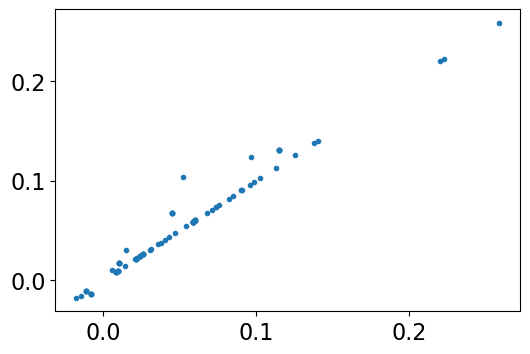

In [16]:
plt.plot(SSMI_lwps_adj, SSMI_lwps, '.')

LinregressResult(slope=0.27125382479774235, intercept=0.022634217660189686, rvalue=0.5652208001359098, pvalue=3.8441635967936e-11, stderr=0.03707895571318919)


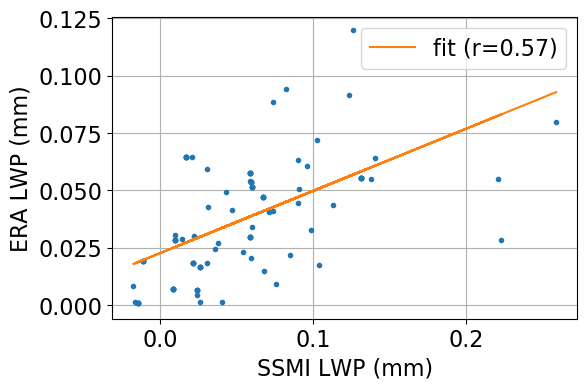

In [17]:
fig, ax = plt.subplots()
ax.plot(SSMI_lwps, ERA_lwps, '.')
ax.set_xlabel('SSMI LWP (mm)')
ax.set_ylabel('ERA LWP (mm)')
ax.plot([0,max(SSMI_lwps+ERA_lwps)],[0,max(SSMI_lwps+ERA_lwps)], '--k')
ax.grid(True)

good = np.logical_and(~np.isnan(SSMI_lwps), ~np.isnan(ERA_lwps))
lr = linregress(np.array(SSMI_lwps)[good], np.array(ERA_lwps)[good])
print(lr)
ax.plot(SSMI_lwps, lr.intercept+lr.slope*np.array(SSMI_lwps), label=f'fit (r={lr.rvalue:0.2f})')
ax.legend()

In [18]:
ERA_inv_norm = [i['z_mid'] for i in old_ERA_invs]
ERA_inv_corr = [i['z_mid'] for i in new_ERA_invs]
prof_inv = [i['z_mid'] for i in prof_invs]

LinregressResult(slope=0.6891690751816527, intercept=582.0483774594682, rvalue=0.6955802119094499, pvalue=3.0040072645311857e-57, stderr=0.036278039338125956)
LinregressResult(slope=0.8336459719198489, intercept=420.6068497950989, rvalue=0.7467497859175031, pvalue=3.5287176510437546e-70, stderr=0.037841334567194476)


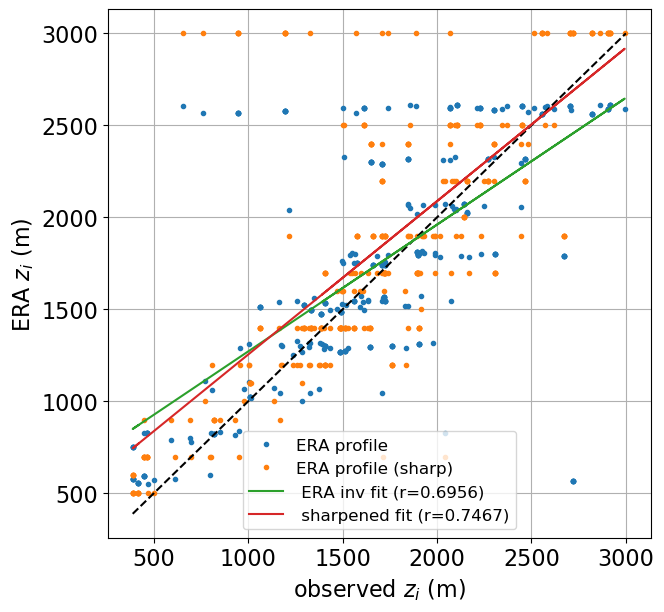

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(prof_inv, ERA_inv_norm, '.', label='ERA profile')
ax.plot(prof_inv, ERA_inv_corr, '.', label='ERA profile (sharp)')
ax.set_xlabel('observed $z_i$ (m)')
ax.set_ylabel('ERA $z_i$ (m)')
ax.plot([min(prof_inv+ERA_inv_norm+ERA_inv_corr),max(prof_inv+ERA_inv_norm+ERA_inv_corr)],
        [min(prof_inv+ERA_inv_norm+ERA_inv_corr),max(prof_inv+ERA_inv_norm+ERA_inv_corr)],
        '--k')
ax.grid(True)

good = np.logical_and(np.logical_and(~np.isnan(prof_inv), ERA_inv_norm), ERA_inv_corr)
lr = linregress(np.array(prof_inv)[good], np.array(ERA_inv_norm)[good])
print(lr)
ax.plot(prof_inv, lr.intercept+lr.slope*np.array(prof_inv), label=f' ERA inv fit (r={lr.rvalue:0.4f})')
lr = linregress(np.array(prof_inv)[good], np.array(ERA_inv_corr)[good])
print(lr)
ax.plot(prof_inv, lr.intercept+lr.slope*np.array(prof_inv), label=f' sharpened fit (r={lr.rvalue:0.4f})')
ax.legend(fontsize=12)

LinregressResult(slope=0.7024543733120984, intercept=121.74301606630365, rvalue=0.725207889261363, pvalue=2.2271823235866272e-64, stderr=0.033989758873763265)
LinregressResult(slope=0.7809875706660644, intercept=417.4423352585077, rvalue=0.703058844358459, pvalue=5.7750354240958575e-59, stderr=0.04025984566331542)


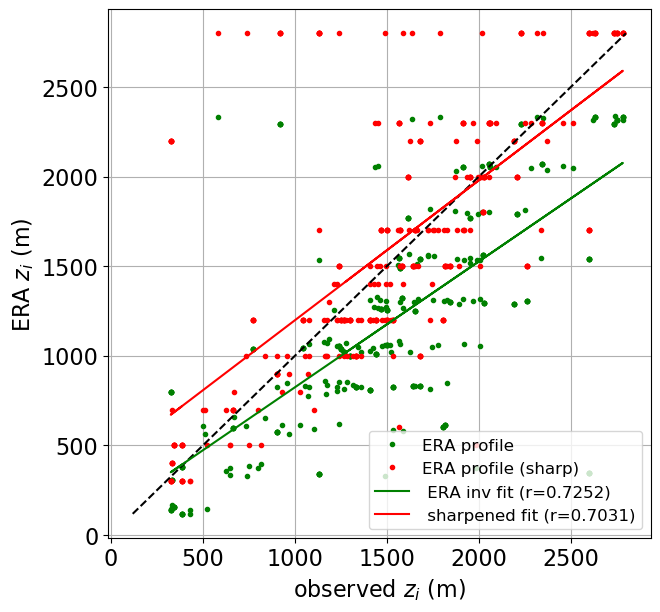

In [22]:
ERA_inv_norm = [i['z_bot'] for i in old_ERA_invs]
ERA_inv_corr = [i['z_bot'] for i in new_ERA_invs]
prof_inv = [i['z_bot'] for i in prof_invs]

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(prof_inv, ERA_inv_norm, '.g', label='ERA profile')
ax.plot(prof_inv, ERA_inv_corr, '.r', label='ERA profile (sharp)')
ax.set_xlabel('observed $z_i$ (m)')
ax.set_ylabel('ERA $z_i$ (m)')
ax.plot([min(prof_inv+ERA_inv_norm+ERA_inv_corr),max(prof_inv+ERA_inv_norm+ERA_inv_corr)],
        [min(prof_inv+ERA_inv_norm+ERA_inv_corr),max(prof_inv+ERA_inv_norm+ERA_inv_corr)],
        '--k')
ax.grid(True)

good = np.logical_and(np.logical_and(~np.isnan(prof_inv), ERA_inv_norm), ERA_inv_corr)
lr = linregress(np.array(prof_inv)[good], np.array(ERA_inv_norm)[good])
print(lr)
ax.plot(prof_inv, lr.intercept+lr.slope*np.array(prof_inv), 'g', label=f' ERA inv fit (r={lr.rvalue:0.4f})')
lr = linregress(np.array(prof_inv)[good], np.array(ERA_inv_corr)[good])
print(lr)
ax.plot(prof_inv, lr.intercept+lr.slope*np.array(prof_inv), 'r', label=f' sharpened fit (r={lr.rvalue:0.4f})')
ax.legend(fontsize=12)

In [34]:
random_snd = list(sounding_data.keys())[31]
#11 demonstrates LWP - slightly too sharp
#13: more LWP experiments
#15: oversharpening, but LWP looks better?
#31: great success! slight bias introduced in inv height, but better! 
#32: mild failure, because the inv height was initially wrong
#we developed this with sounding_data 29
#note: 10 is a good example of ERA nailing it
# 13 is ERA being reasonable, reality being complex
# 30 is complicated- ERA is wrong, but how to correct?
data = sounding_data[random_snd]
lat, lon, date = data['GGLAT'][0], data['GGLON'][0]%360, data['TIME'][0]
ERA_profile = ERA_data.sel(time=date, method='nearest', tolerance=np.timedelta64(1, 'h'))
ERA_profile = ERA_profile.sel(latitude=lat, longitude=lon, method='nearest', tolerance=0.5)
dummy_ds = xr.Dataset(coords={'time': [date.replace(tzinfo=None)], 'lat': [lat], 'lon': [lon]})
ds = add_SSMI_to_trajectory(dummy_ds, hour_tolerance=2)
SSMI_lwp = ds.SSMI_LWP.values[0]


In [25]:
random_prof = list(profile_data.keys())[11]
data = profile_data[random_prof]

In [178]:
#make the sharpest possible inversion
#dry adiabat at ERA inv top:
z_old, t, p, r = ERA_profile.z.values.copy()/9.81, ERA_profile.t.values.copy(), ERA_profile.level.values.copy(), ERA_profile.r.values.copy()
ql = ERA_profile.clwc.values.copy()


ERA_inv_old = met_utils.quick_inversion(z_old, t, p)

z = np.arange(7000, np.ceil(min(z_old)/100)*100, -100)
t = interp1d(z_old, t)(z)
p = interp1d(z_old, p)(z)
r = interp1d(z_old, r)(z)
ql = interp1d(z_old, ql)(z)

rho = met_utils.density_from_p_Tv(p*100, met_utils.tvir_from_T_w(t, ql))


qv = met_utils.qv_from_p_T_RH(p*100, t, r)
qsat = met_utils.qvs_from_p_T(p*100, t)



ERA_inv = met_utils.quick_inversion(z, t, p)

lwp_bl = -np.trapz((ql*rho)[z<ERA_inv['z_top']], z[z<ERA_inv['z_top']]) # should be in kg/m3
lwp_tot = -np.trapz((ql*rho), z) # should be in kg/m3

inv = ERA_inv

assert(np.all(np.diff(z)<0)) # gotta have a descending profile. When this breaks, flip it
#~moist lapse rate from inv top to surface
#ft_lapse_rate = 9.8
ft_lapse_rate = 6.5
t_ft_dry = t[inv['i_top']] - ft_lapse_rate*(z - z[inv['i_top']])/1000


#surface LCL
t_dew = t-(100-r)/5.0
lcl = met_utils.calculate_LCL(t, t_dew, z)
lower_bl_lcl = np.nanmax([np.nanmean(lcl[z<inv['z_bot']/2]), np.nanmin(z)])
i_lcl = np.nanargmin(np.abs(z-lower_bl_lcl))
lower_bl_lcl = z[i_lcl] # just fixing it to a pressure level
lower_bl_lcl = inv['z_bot']
i_lcl = inv['i_bot']
#actual moist adiabatic lapse rate from sfc lcl
gamma_m = met_utils.get_moist_adiabatic_lapse_rate(t, p)
base_of_moist_adiabat = lower_bl_lcl
cumsums = np.insert(np.cumsum(np.diff(z)*(gamma_m[1:] + gamma_m[:-1])/2), 0, 0)

t_bl_moist = t[i_lcl] + cumsums[i_lcl] - cumsums

middle_t = (t_ft_dry[inv['i_mid']]+t_bl_moist[inv['i_mid']])/2
t_sharpest_inv = np.concatenate((
    t[0:inv['i_top']],
    t_ft_dry[inv['i_top']:inv['i_mid']], 
    [middle_t], 
    t_bl_moist[inv['i_mid']+1:i_lcl],
    t[i_lcl:]))


ERA_inv_new = met_utils.quick_inversion(z, t_sharpest_inv, p)

qsat_new = met_utils.qvs_from_p_T(p*100, t_sharpest_inv)
q_oversat = qsat-qsat_new
q_move_to_l = q_oversat
#maybe split the BL and FT?
q_move_to_l[q_move_to_l<0] = 0
q_move_to_l[z>inv['z_mid']] = 0
ql_new = ql+q_move_to_l
lwp_bl_new = -np.trapz((ql_new*rho)[z<ERA_inv['z_top']], z[z<ERA_inv['z_top']]) # should be in kg/m3


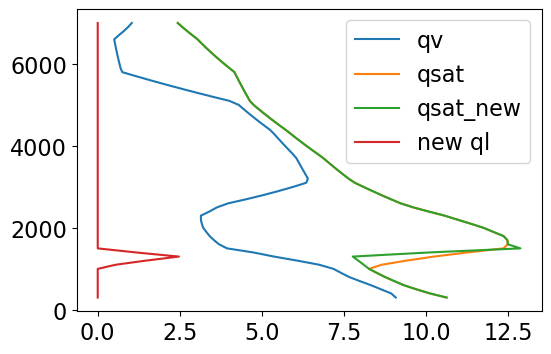

In [32]:
plt.plot(qv*1000, z, label='qv')
plt.plot(qsat*1000, z, label='qsat')
plt.plot(qsat_new*1000, z, label='qsat_new')
plt.plot(q_move_to_l*1000, z, label='new ql')
# plt.plot(data['RHUM'], data['GGALT'])
plt.legend()

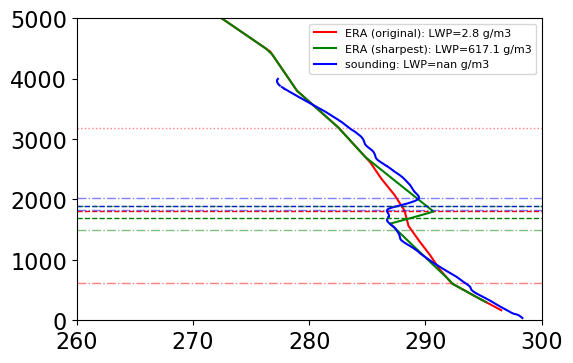

In [36]:
fig, ax = plt.subplots()
ax.plot(ERA_profile.t, ERA_profile.z/9.81, c='r', label=f'ERA (original): LWP={lwp_bl*1000:0.1f} g/m3')
ax.axhline(ERA_inv_old['z_top'], ls=':', lw=1, c='r', alpha=0.5)
ax.axhline(ERA_inv_old['z_bot'], ls='-.', lw=1, c='r', alpha=0.5)
ax.axhline(ERA_inv_old['z_mid'], ls='--', lw=1, c='r', alpha=1)
# ax.axhline(lower_bl_lcl, ls=':', lw=1, c='r', alpha=0.5)
# ax.plot(t_ft_dry[z>=ERA_inv['z_mid']], z[z>=ERA_inv['z_mid']], 'g')
# ax.plot(t_bl_moist[z<=ERA_inv['z_mid']], z[z<=ERA_inv['z_mid']], 'g')
ax.plot(t_sharpest_inv, z, 'g', label=f'ERA (sharpest): LWP={lwp_bl_new*1000:0.1f} g/m3')
ax.set_ylim(0, 5000)
ax.set_xlim(260, 300)
ax.plot(data['ATX'], data['GGALT'], 'b', label=f'sounding: LWP={SSMI_lwp*1000:0.1f} g/m3')
ax.axhline(data['dec']['z_top'], ls='-.', lw=1, c='b', alpha=0.5)
ax.axhline(data['dec']['z_bot'], ls='-.', lw=1, c='b', alpha=0.5)
ax.axhline(data['dec']['z_mid'], ls='--', lw=1, c='b', alpha=1)
ax.axhline(ERA_inv_new['z_mid'], ls='--', lw=1, c='g', alpha=1)
ax.axhline(ERA_inv_new['z_bot'], ls='-.', lw=1, c='g', alpha=0.5)
ax.axhline(ERA_inv_new['z_top'], ls='-.', lw=1, c='g', alpha=0.5)
ax.legend(fontsize=8)

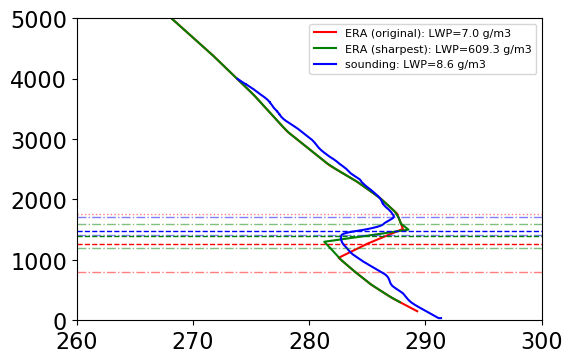

In [350]:
fig, ax = plt.subplots()
ax.plot(ERA_profile.t, ERA_profile.z/9.81, c='r', label=f'ERA (original): LWP={lwp_bl*1000:0.1f} g/m3')
ax.axhline(ERA_inv_old['z_top'], ls=':', lw=1, c='r', alpha=0.5)
ax.axhline(ERA_inv_old['z_bot'], ls='-.', lw=1, c='r', alpha=0.5)
ax.axhline(ERA_inv_old['z_mid'], ls='--', lw=1, c='r', alpha=1)
# ax.axhline(lower_bl_lcl, ls=':', lw=1, c='r', alpha=0.5)
# ax.plot(t_ft_dry[z>=ERA_inv['z_mid']], z[z>=ERA_inv['z_mid']], 'g')
# ax.plot(t_bl_moist[z<=ERA_inv['z_mid']], z[z<=ERA_inv['z_mid']], 'g')
ax.plot(t_sharpest_inv, z, 'g', label=f'ERA (sharpest): LWP={lwp_bl_new*1000:0.1f} g/m3')
ax.set_ylim(0, 5000)
ax.set_xlim(260, 300)
ax.plot(data['ATX'], data['GGALT'], 'b', label=f'sounding: LWP={SSMI_lwp*1000:0.1f} g/m3')
ax.axhline(data['dec']['z_top'], ls='-.', lw=1, c='b', alpha=0.5)
ax.axhline(data['dec']['z_bot'], ls='-.', lw=1, c='b', alpha=0.5)
ax.axhline(data['dec']['z_mid'], ls='--', lw=1, c='b', alpha=1)
ax.axhline(ERA_inv_new['z_mid'], ls='--', lw=1, c='g', alpha=1)
ax.axhline(ERA_inv_new['z_bot'], ls='-.', lw=1, c='g', alpha=0.5)
ax.axhline(ERA_inv_new['z_top'], ls='-.', lw=1, c='g', alpha=0.5)
ax.legend(fontsize=8)

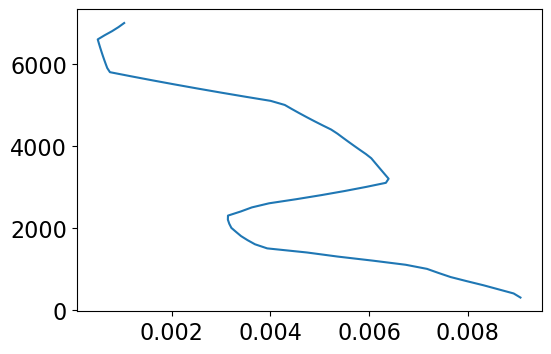

In [354]:
plt.plot(qv, z)